# 1 Spike Preprocessing: Sorting

### 1.1 Getting Started

In [79]:
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
from sklearn import svm
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle

In [2]:
extra_data = scipy.io.loadmat('extracellular.mat')
extra_data = extra_data['all_data_with_noise_and_line'][0]

Text(0, 0.5, 'amplitude')

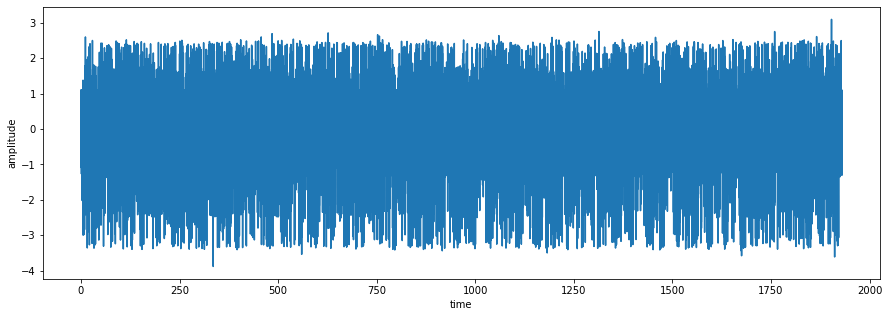

In [3]:
freq = 2400
T = 1/freq
time = [i*T for i in range(len(extra_data))]
plt.figure(figsize=(15,5))
plt.plot(time,extra_data)
plt.xlabel('time')
plt.ylabel('amplitude')

Text(0.5, 0, 'Data')

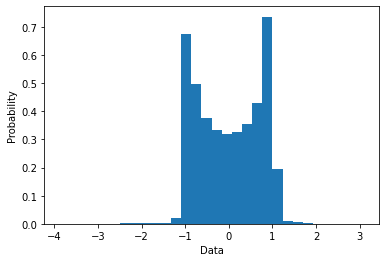

In [4]:
plt.hist(extra_data,density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Data')

### 1.2 Filtering the Data

In [5]:
fs = 2400
order = 7
nyq = 0.5 * fs
cutoff = 300
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
filtered_extra = signal.filtfilt(b, a, extra_data)

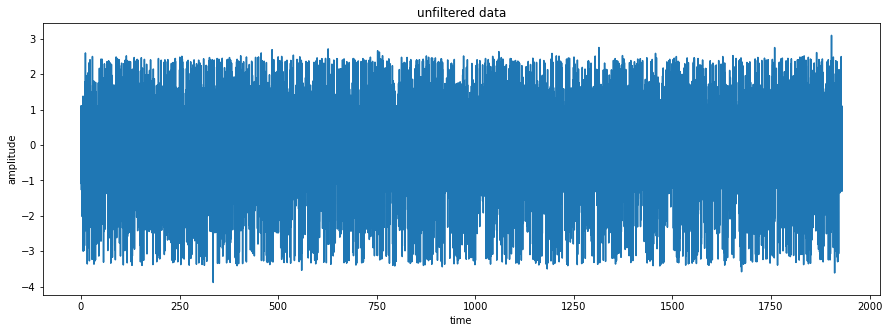

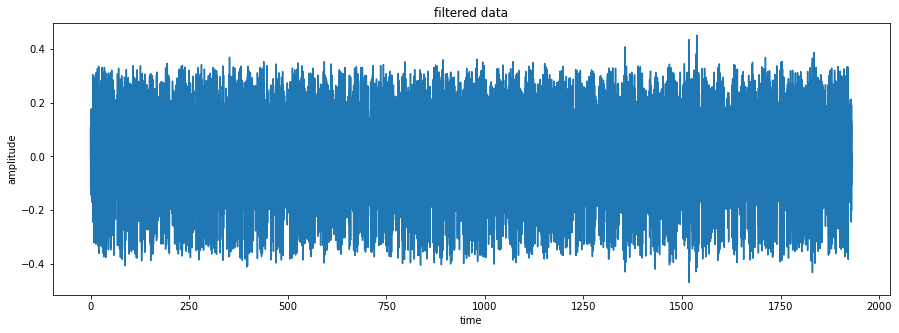

In [6]:
time = [i*T for i in range(len(extra_data))]
plt.figure(figsize=(15,5))
plt.plot(time,extra_data)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('unfiltered data')
plt.show()
plt.figure(figsize=(15,5))
plt.plot(time,filtered_extra)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('filtered data')
plt.show()

### 1.3 Detecting the Spike

In [7]:
theta = 5*np.median(np.absolute(filtered_extra)/0.6745)

In [8]:
dy = np.zeros(filtered_extra.shape,float)
dy[0:-1] = np.diff(filtered_extra)/np.diff(time)
dy[-1] = (filtered_extra[-1] - filtered_extra[-2])/(time[-1] - time[-2])

In [9]:
spikes_idx = [dy_idx for dy_idx in range(1,len(dy)-1) if np.sign(dy[dy_idx-1])!=np.sign(dy[dy_idx+1])]

In [10]:
spikes_idx_above_th = np.array([idx for idx in spikes_idx if np.absolute(filtered_extra[idx])>=theta])

In [11]:
spikes_matrix = np.array([filtered_extra[idx-5:idx+6] for idx in spikes_idx_above_th])

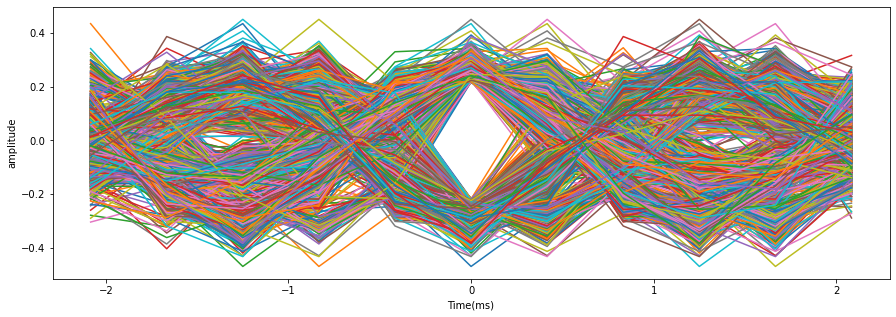

In [12]:
plt.figure(figsize=(15,5))
plt.xlabel('Time(ms)')
plt.ylabel('amplitude')
t = np.linspace(-5/fs,5/fs,11)*1000
for spike_wave in spikes_matrix:
    plt.plot(t,spike_wave)
plt.show()

### 1.4 Extracting Features

In [13]:
pca = PCA(n_components=3)
pca_waveform = pca.fit_transform(spikes_matrix)
pca.explained_variance_ratio_

array([0.79118473, 0.11971564, 0.04195332])

In [14]:
pca_waveform.shape

(5246, 3)

In [15]:
pca_waveform

array([[-0.40862842,  0.16269375,  0.06092875],
       [ 0.60288156, -0.07274827,  0.0171836 ],
       [-0.38446393, -0.11849659, -0.08208229],
       ...,
       [ 0.67553859, -0.03024787,  0.02955533],
       [-0.49426246, -0.1730755 , -0.13449943],
       [ 0.37544973, -0.00088551,  0.03389063]])

### 1.5 Clustering the Spikes

In [16]:
def draw_clusters(pca_waveform):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

    sse = []
    for k in range(1, 8):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        identified_clusters = kmeans.fit_predict(pca_waveform)
        sse.append(kmeans.inertia_)
        print("k = ",k)
        figure, axis = plt.subplots(1,3,figsize=(8,2),constrained_layout = True)
        axis[0].scatter(pca_waveform[:,0],pca_waveform[:,1],c=identified_clusters,cmap='coolwarm')
        axis[0].set_xlabel('C1')
        axis[0].set_ylabel('C2')
    
        axis[1].scatter(pca_waveform[:,0],pca_waveform[:,2],c=identified_clusters,cmap='coolwarm')
        axis[1].set_xlabel('C1')
        axis[1].set_ylabel('C3')
    
        axis[2].scatter(pca_waveform[:,1],pca_waveform[:,2],c=identified_clusters,cmap='coolwarm')
        axis[2].set_xlabel('C2')
        axis[2].set_ylabel('C3')
    

        plt.show()

    number_clusters = range(1,8)
    plt.plot(number_clusters,sse)
    plt.title('elbow')
    plt.xlabel('number of clusters')
    plt.ylabel('sse')

k =  1


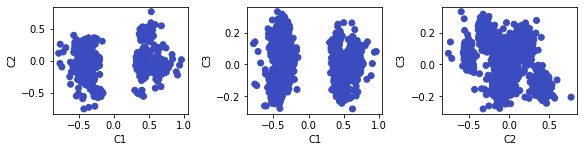

k =  2


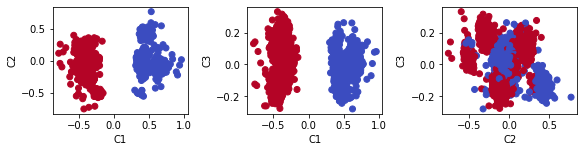

k =  3


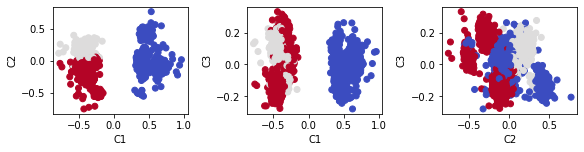

k =  4


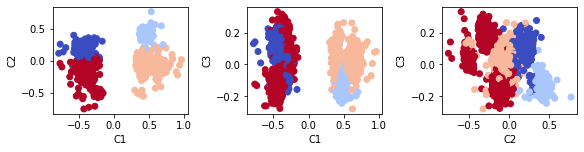

k =  5


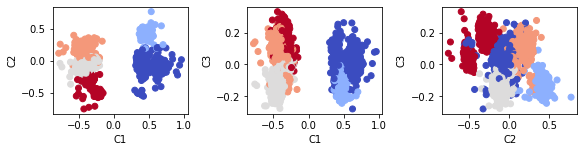

k =  6


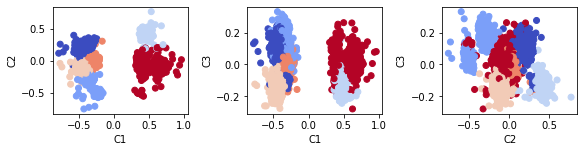

k =  7


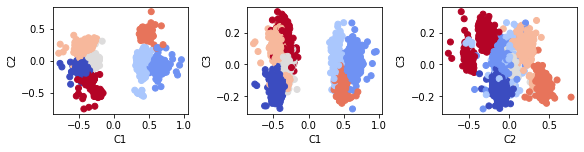

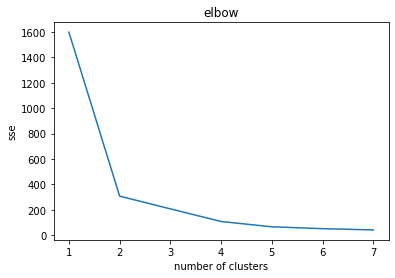

In [17]:
draw_clusters(pca_waveform)

###  real_spikes

In [18]:
real_spike = scipy.io.loadmat('spikes.mat')
real_spike = real_spike['SpikeInds'][0]

In [19]:
real_spikes_matrix = np.array([filtered_extra[idx-5:idx+6] for idx in real_spike])

In [20]:
pca_real = PCA(n_components=3)
pca_real_waveform = pca_real.fit_transform(real_spikes_matrix)
pca_real.explained_variance_ratio_

array([0.90806159, 0.01605219, 0.01242479])

k =  1


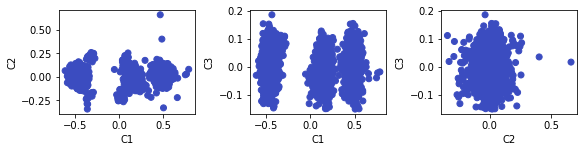

k =  2


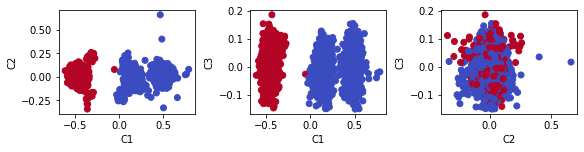

k =  3


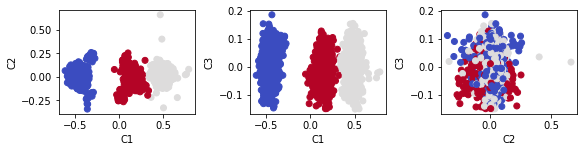

k =  4


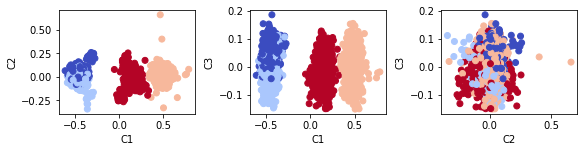

k =  5


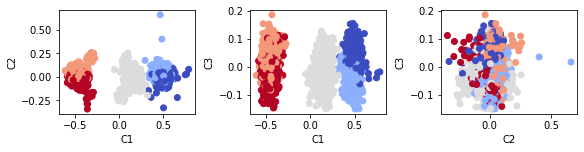

k =  6


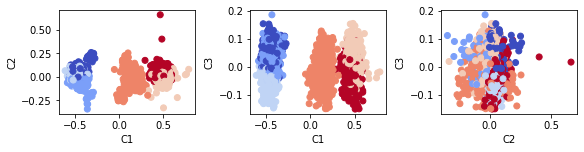

k =  7


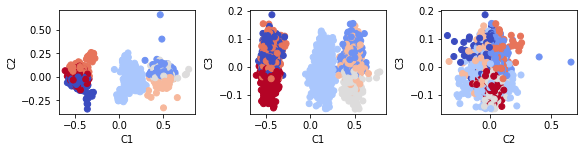

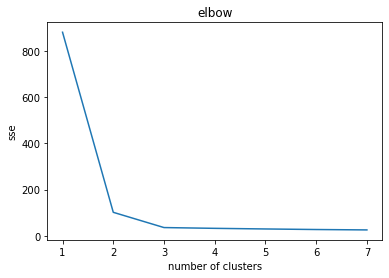

In [21]:
draw_clusters(pca_real_waveform)

In [22]:
def draw_plot(real_waveform,waveform,c1,c2):
    plt.scatter(real_waveform[:,c1-1],real_waveform[:,c2-1],label = 'real')
    plt.scatter(waveform[:,c1-1],waveform[:,c2-1],alpha=0.6,label = 'calculated')
    plt.xlabel('C'+str(c1))
    plt.ylabel('C'+str(c2))
    plt.legend(loc='upper right')
    plt.show()

In [23]:
def find_neighbourhood_distance(data,k):
    tree = KDTree(data)
    max_dist = []
    for point in data:
        dist, ind = tree.query([point], k=k+1)
        max_dist.append(dist[0][k])
    return np.array(max_dist)
    
def is_neighbour(point,data,max_distances):
    for i,data_point in enumerate(data):
        if(np.linalg.norm(point-data_point)<max_distances[i]):
            return 1
    return 0

In [24]:
def eval_spike(real_spike_points,calculated_spike_points,k):
    max_distances = find_neighbourhood_distance(real_spike_points,k)
    coverage = np.zeros(len(calculated_spike_points))
    for i,spike_point in enumerate(calculated_spike_points):
        if(is_neighbour(spike_point,real_spike_points,max_distances)):
               coverage[i]=1
    print('acc=',np.mean(coverage)*(1-np.abs(len(real_spike_points)-len(calculated_spike_points))/len(real_spike_points)))

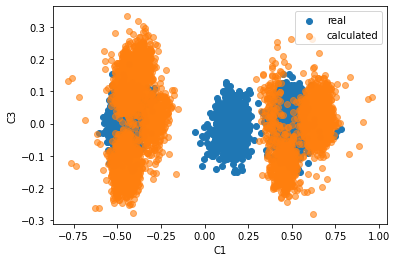

acc= 0.5803079411553772


In [25]:
draw_plot(pca_real_waveform,pca_waveform,1,3)
eval_spike(pca_real_waveform[:,[0,2]],pca_waveform[:,[0,2]],2)

### changing threshold

In [26]:
theta = 0.9*max(filtered_extra)
new_spikes_idx_above_th = np.array([idx for idx in spikes_idx if np.absolute(filtered_extra[idx])>=theta])
new_spikes_matrix = np.array([filtered_extra[idx-5:idx+6] for idx in new_spikes_idx_above_th])
new_pca = PCA(n_components=3)
new_pca_waveform = pca.fit_transform(new_spikes_matrix)

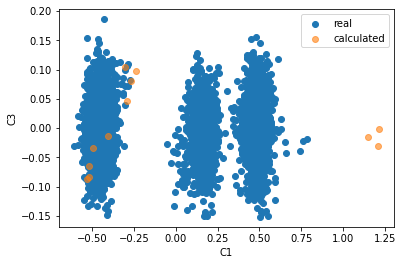

acc= 0.0016739903745553637


In [27]:
draw_plot(pca_real_waveform,new_pca_waveform,1,3)
eval_spike(pca_real_waveform[:,[0,2]],new_pca_waveform[:,[0,2]],2)

### TSNE

In [28]:
model_c = TSNE(n_components=3,learning_rate='auto',init='random')
tsne_calculated = model_c.fit_transform(spikes_matrix) 

In [29]:
model_r = TSNE(n_components=3,learning_rate='auto',init='random')
tsne_real = model_r.fit_transform(real_spikes_matrix) 

real
k =  1


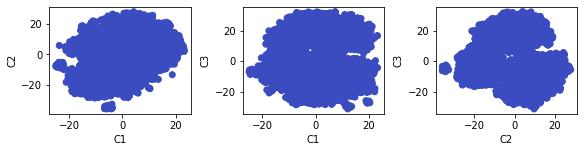

k =  2


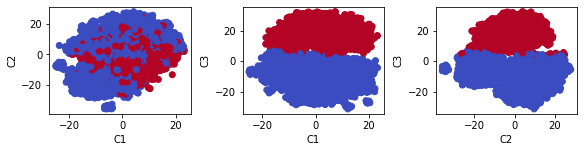

k =  3


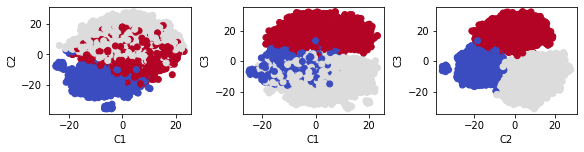

k =  4


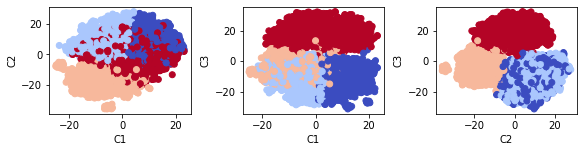

k =  5


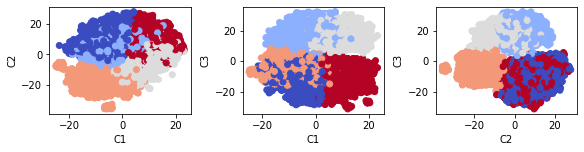

k =  6


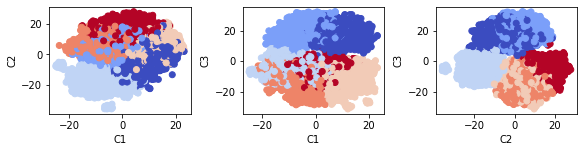

k =  7


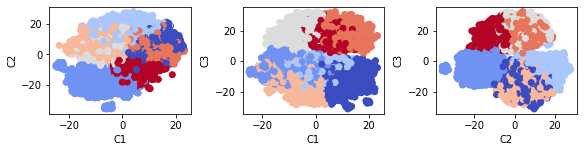

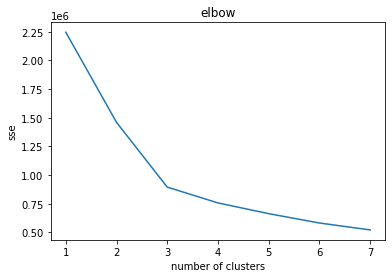

In [30]:
print("real")
draw_clusters(tsne_real)

calculated
k =  1


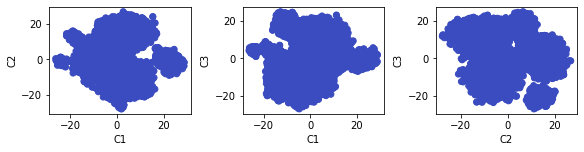

k =  2


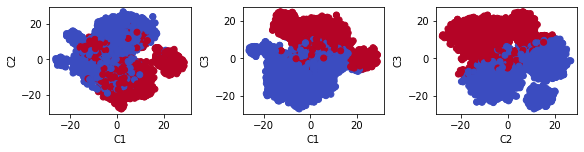

k =  3


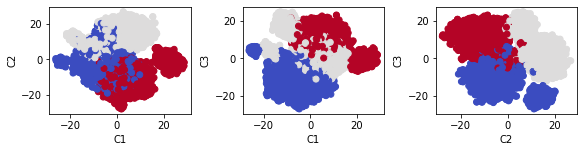

k =  4


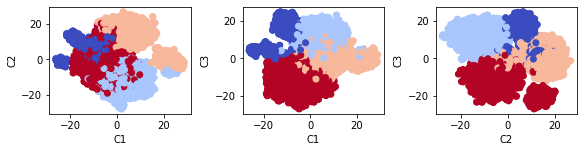

k =  5


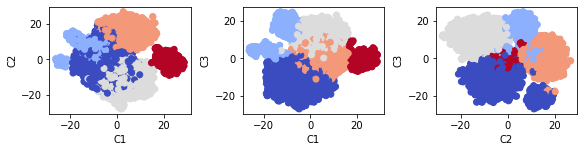

k =  6


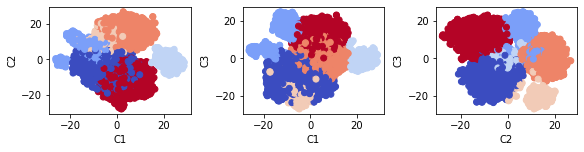

k =  7


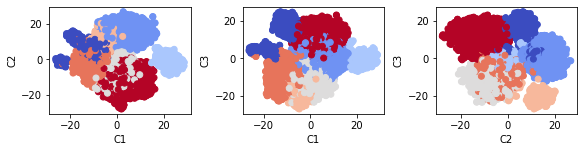

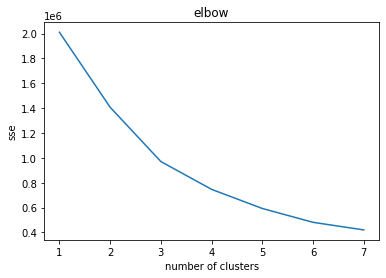

In [31]:
print("calculated")
draw_clusters(tsne_calculated)

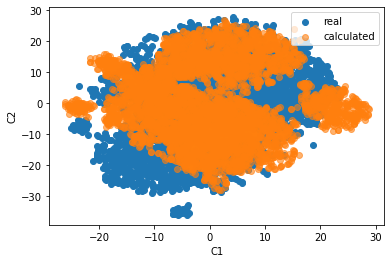

acc= 0.7252989294167829


In [32]:
draw_plot(tsne_real,tsne_calculated,1,2)
eval_spike(tsne_real[:,[1,2]],tsne_calculated[:,[1,2]],2)

# 2 Data Exploring: Discrete-Time Signals

## Raster Plot

In [33]:
elec_data = scipy.io.loadmat('dataset/cond.mat')

In [34]:
stim_data = np.array([s[0] for s in elec_data['Cond']])

In [35]:
stim_dict = {i:np.where(stim_data==i)[0] for i in range(1,17)}

### raster plot for all

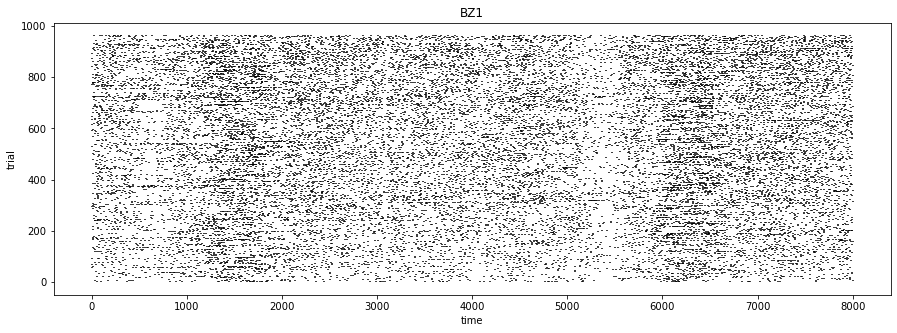

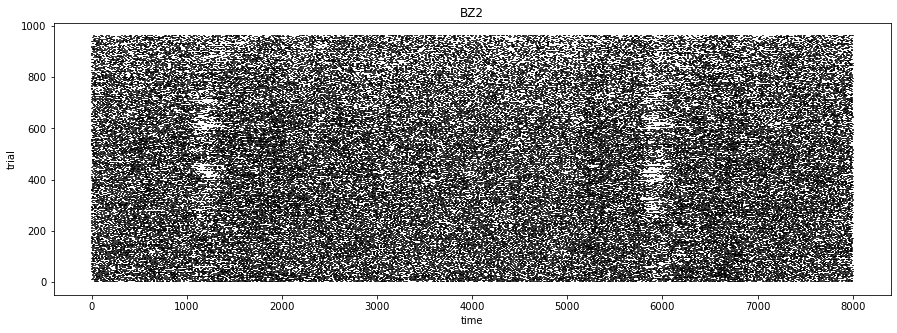

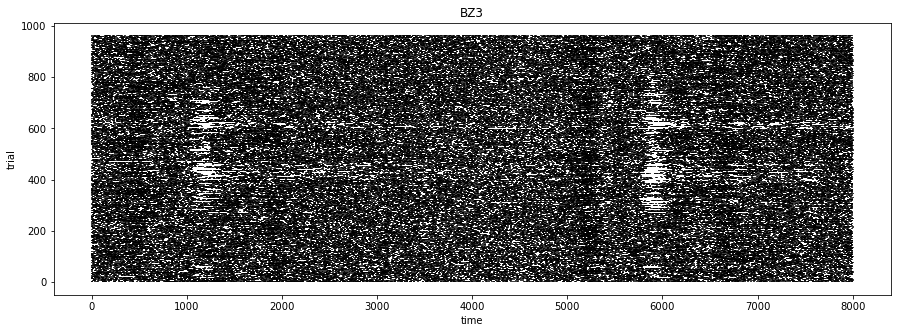

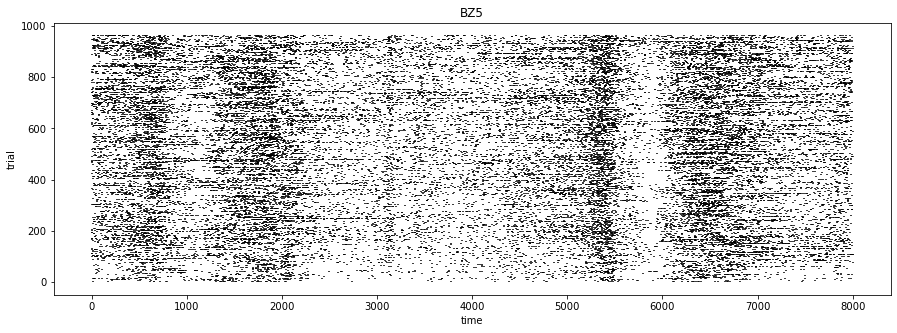

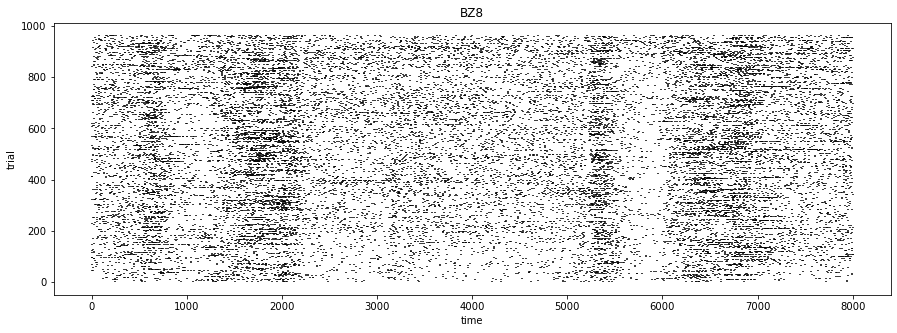

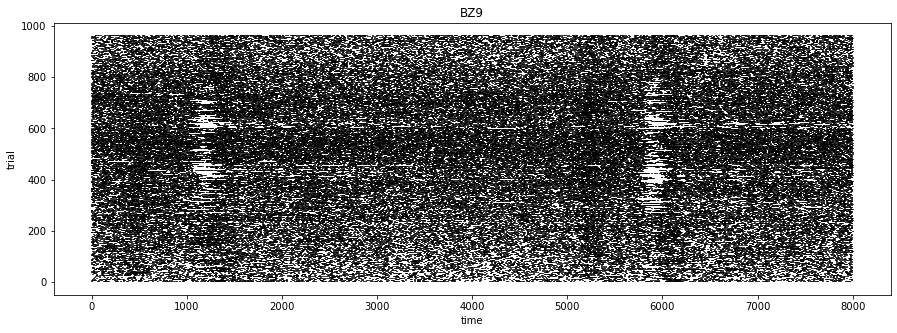

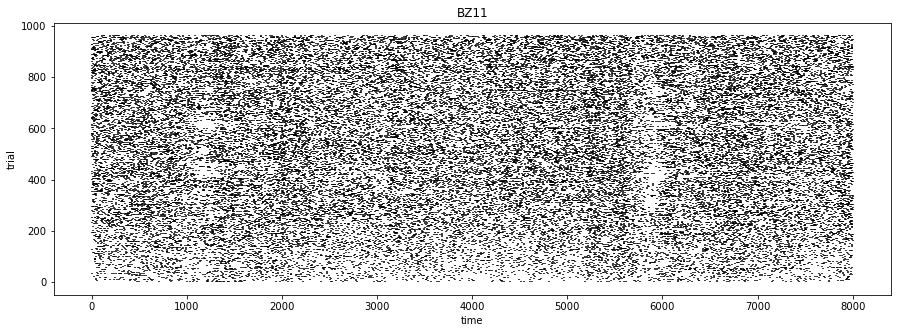

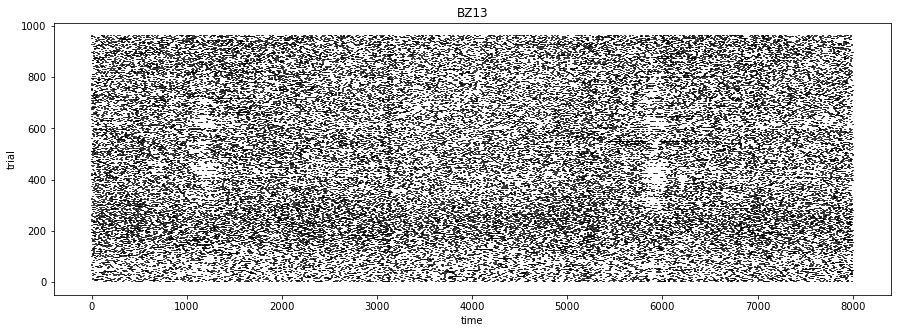

In [36]:
valids = [1,2,3,5,8,9,11,13]
file_names = ['dataset/SpikeActBZ'+str(i) for i in valids]
for i,file_name in enumerate(file_names):
    plt.figure(figsize=(15,5))
    data = scipy.io.loadmat(file_name)['su'][0][0]
    data = [(np.where(data[i] == 1)[0]) for i in range(len(data))]
    plt.eventplot(data,color='black')
    plt.xlabel('time')
    plt.ylabel('trial')
    plt.title('BZ'+str(valids[i]))
    plt.show()     

### rasterplot & PSTH for each

BZ1


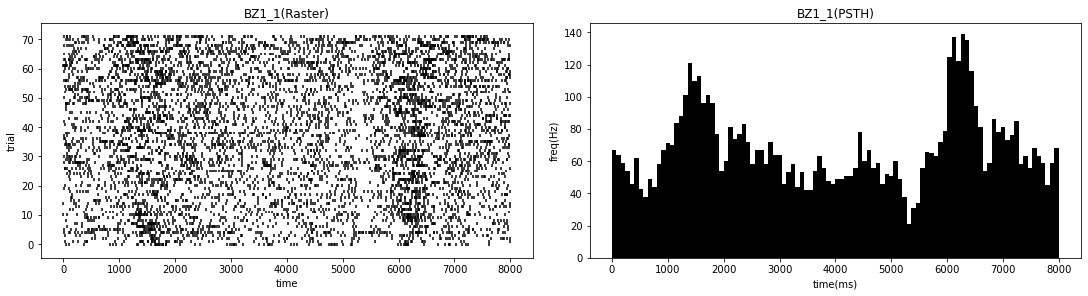

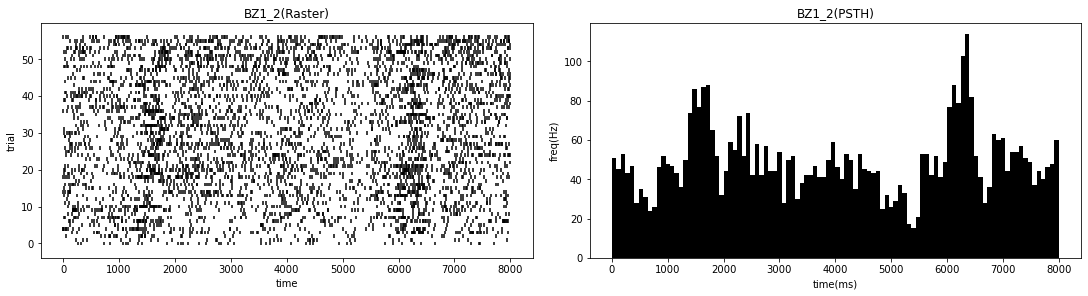

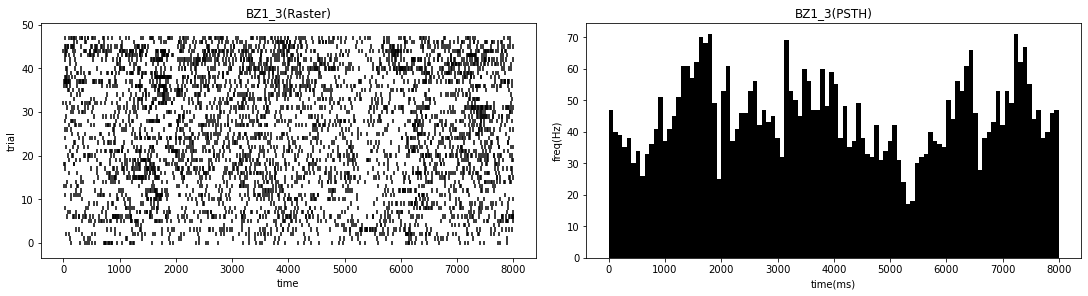

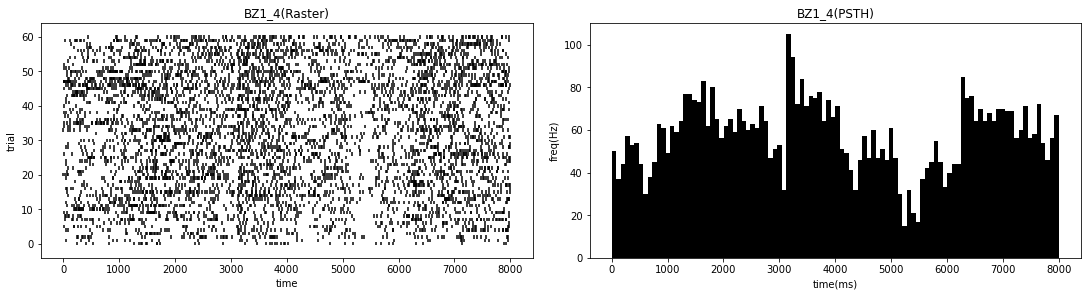

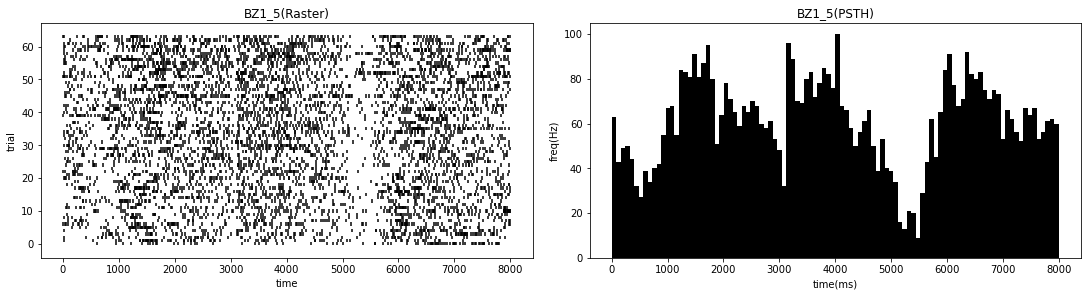

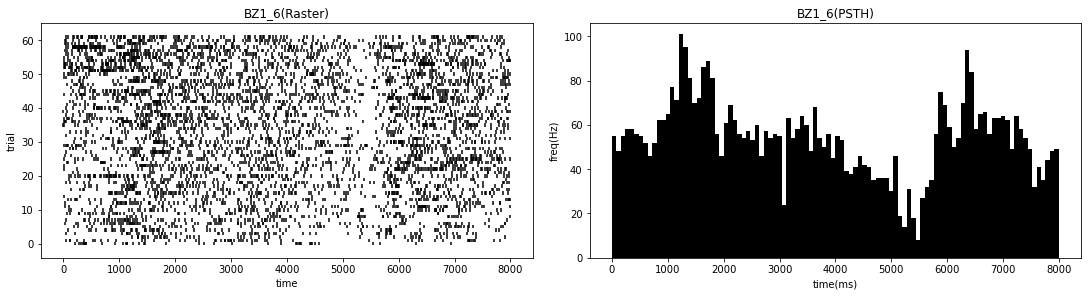

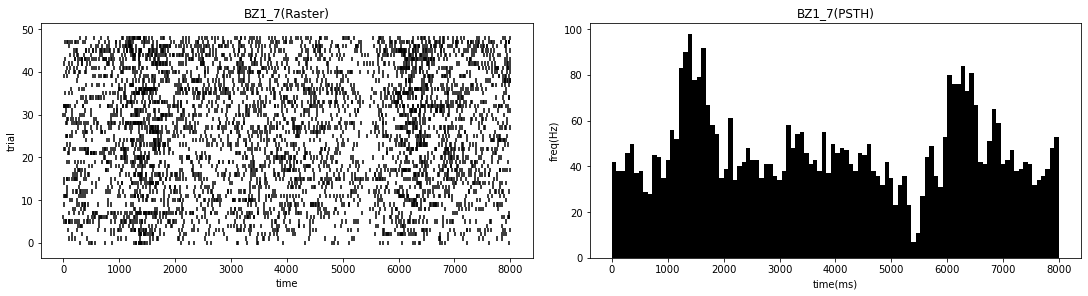

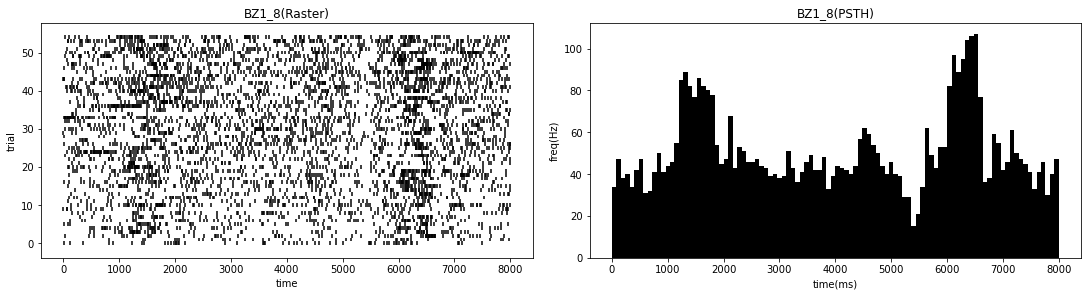

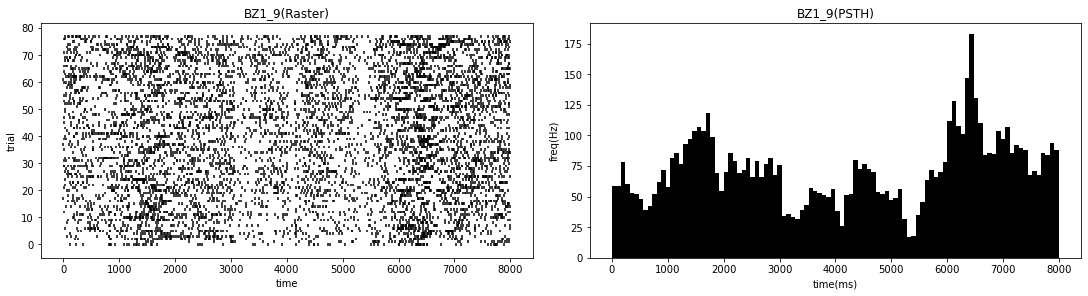

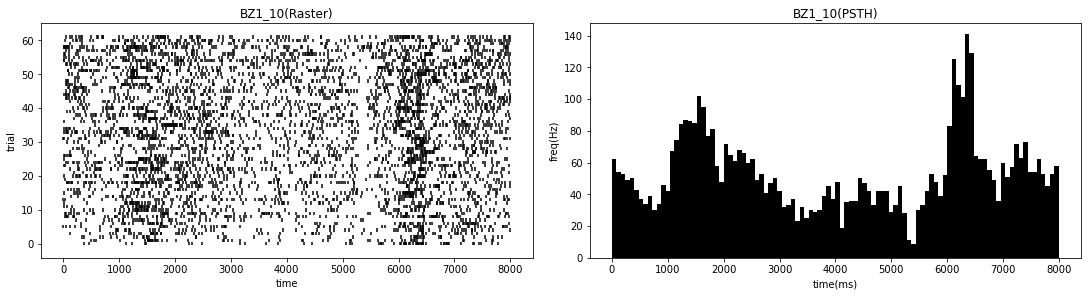

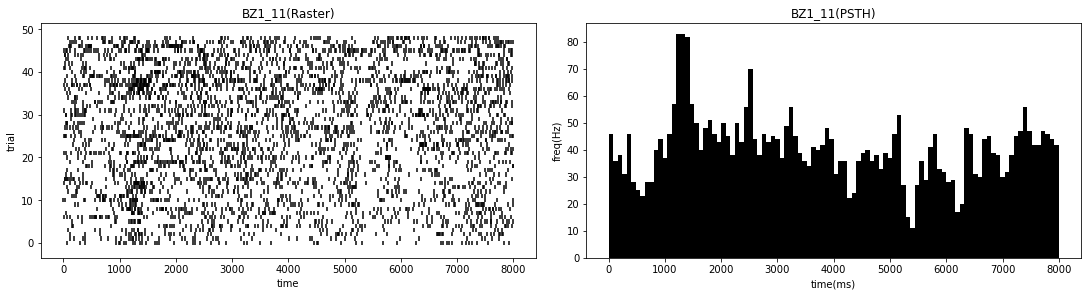

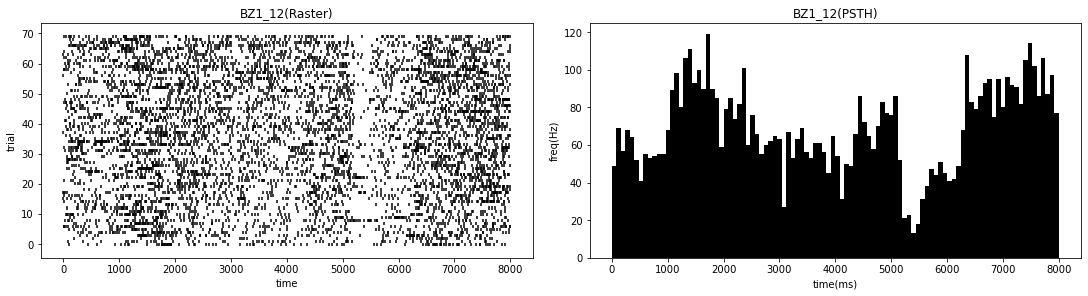

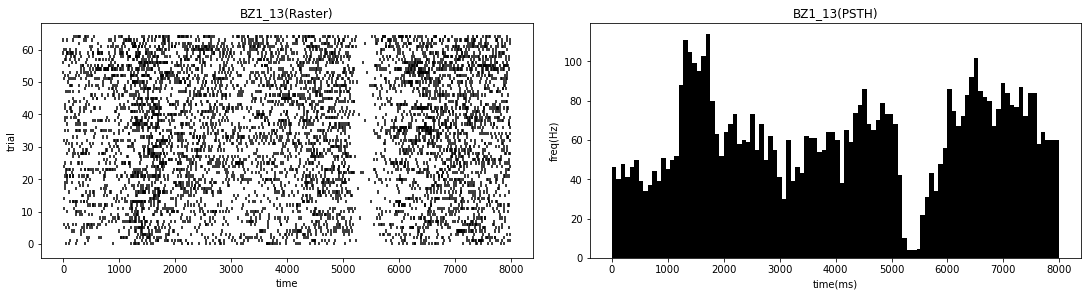

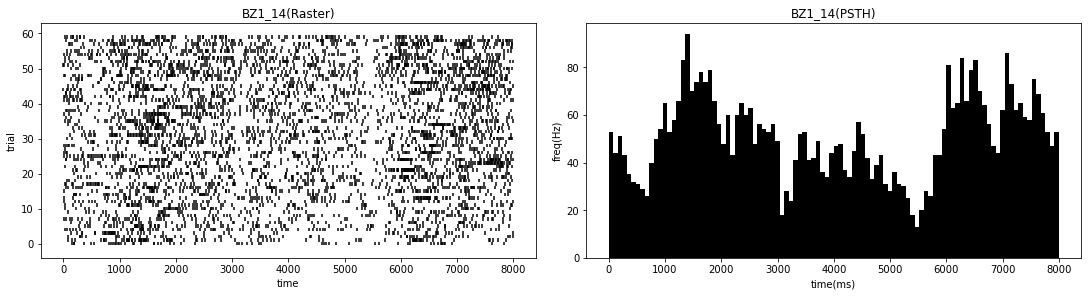

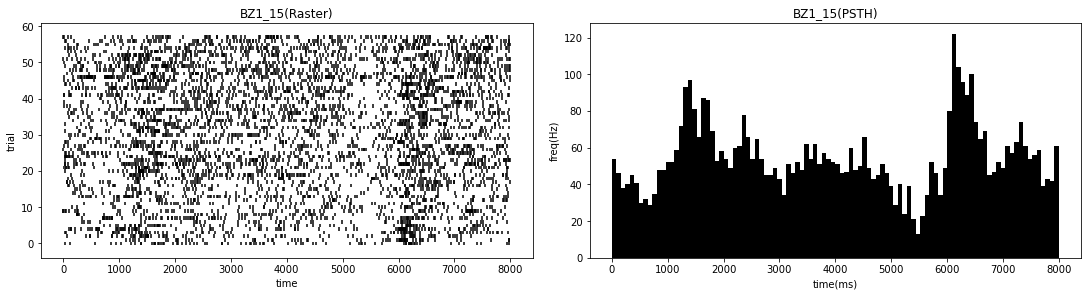

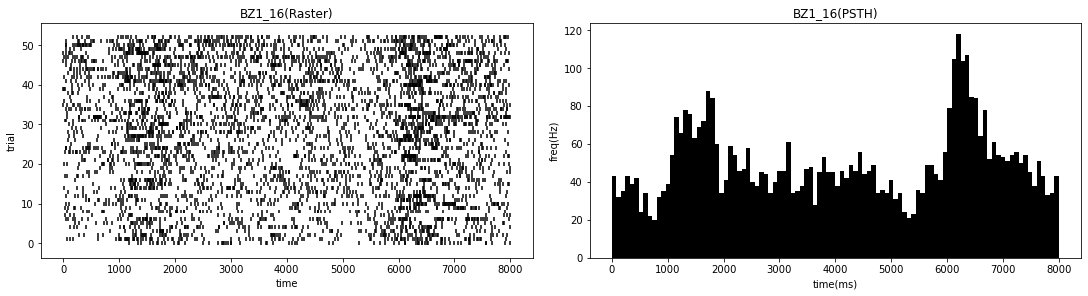

BZ2


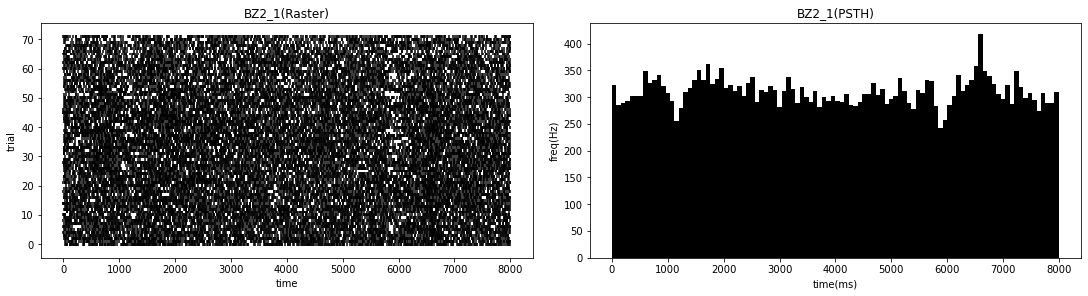

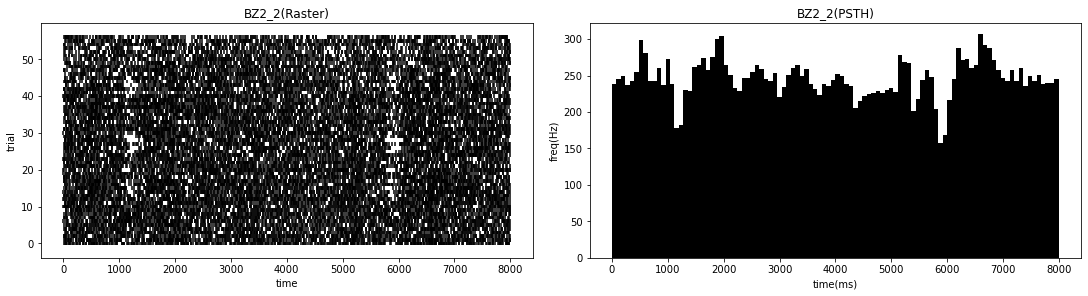

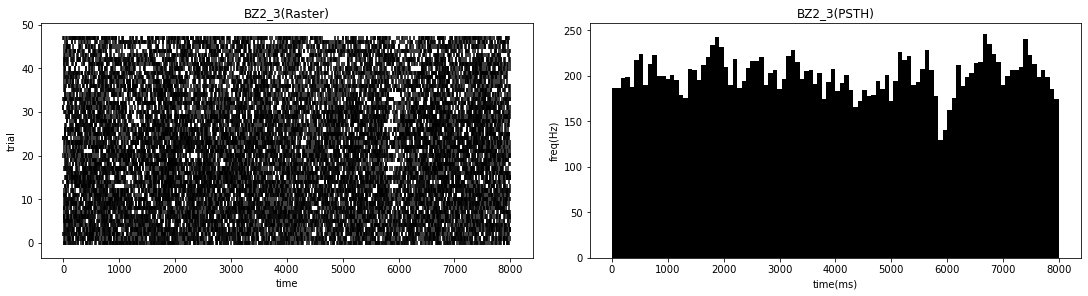

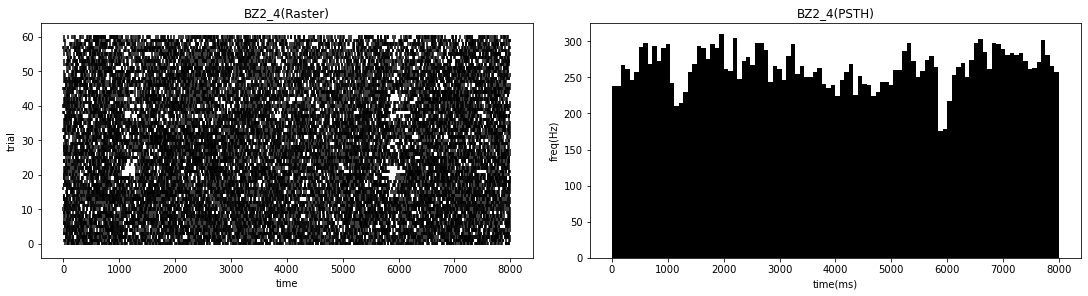

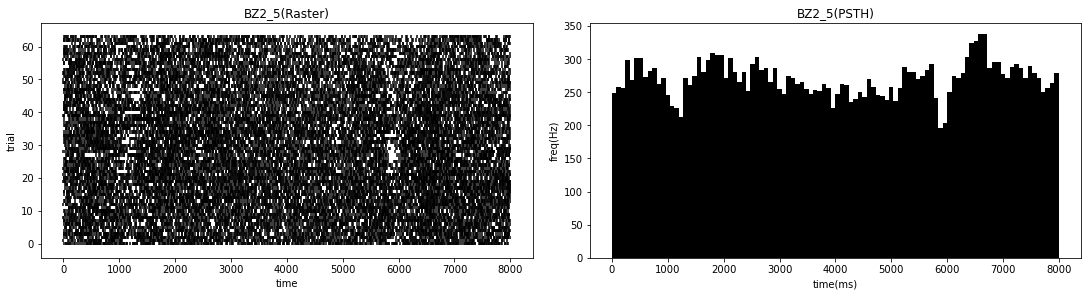

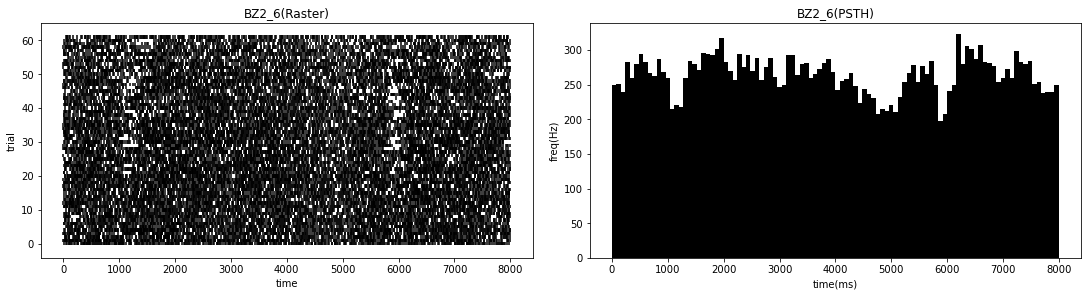

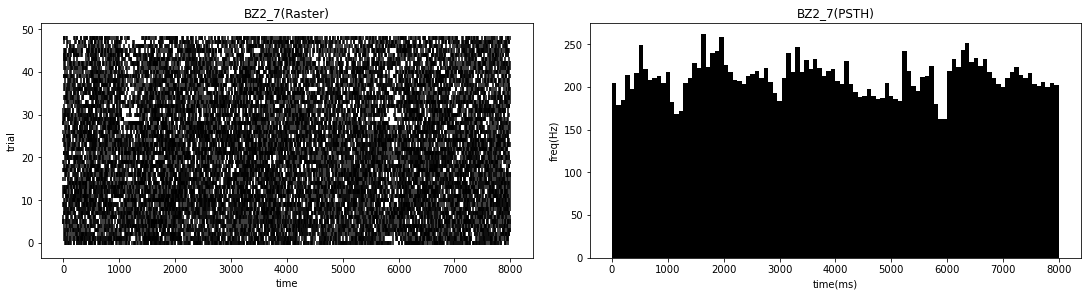

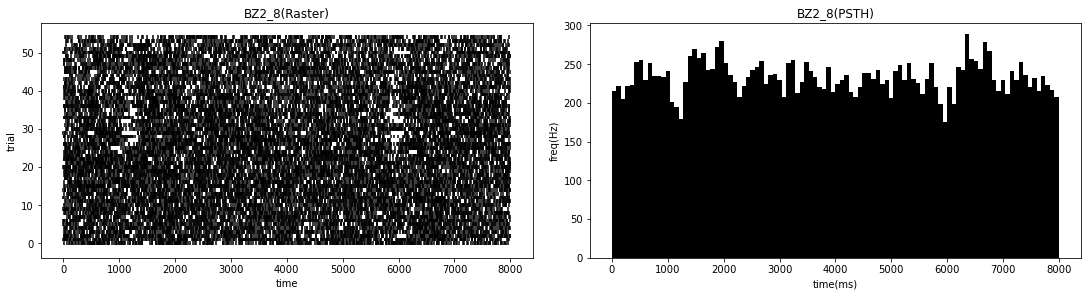

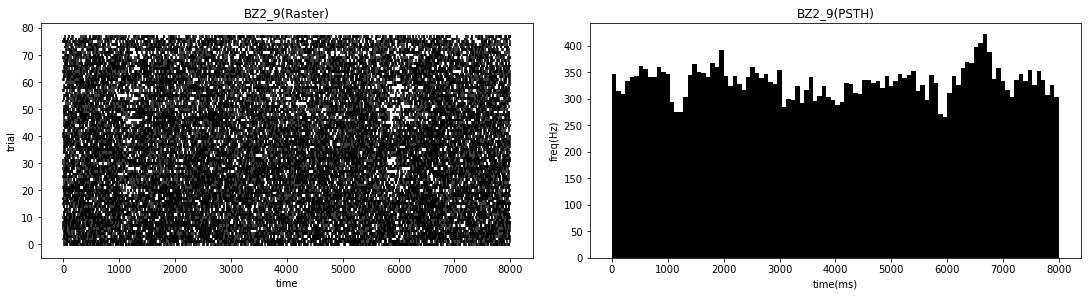

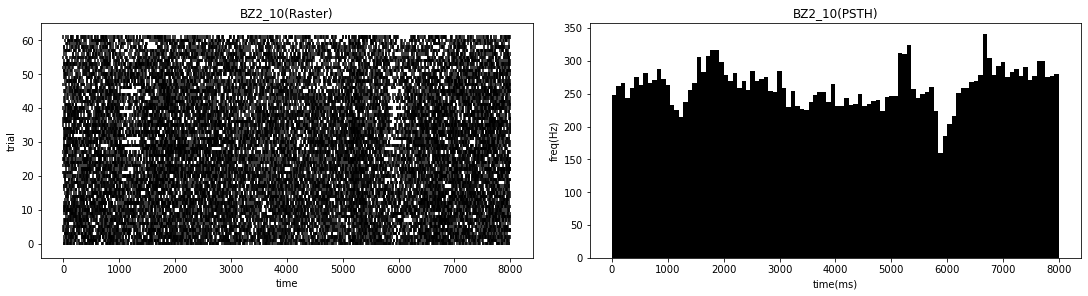

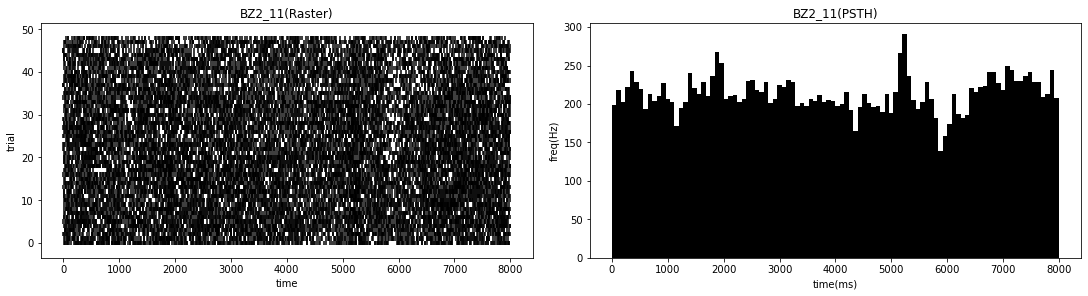

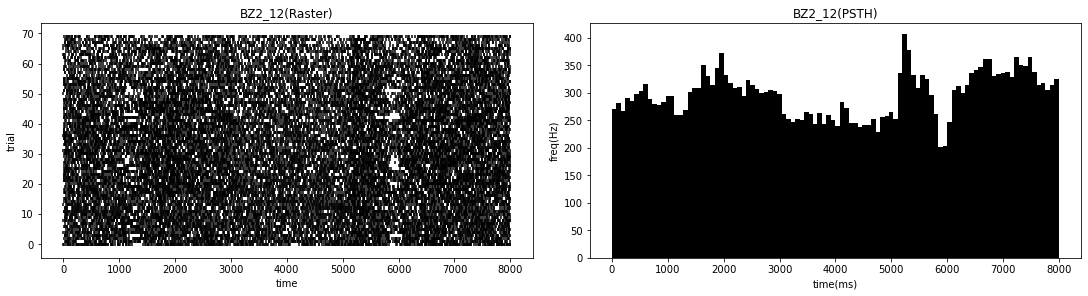

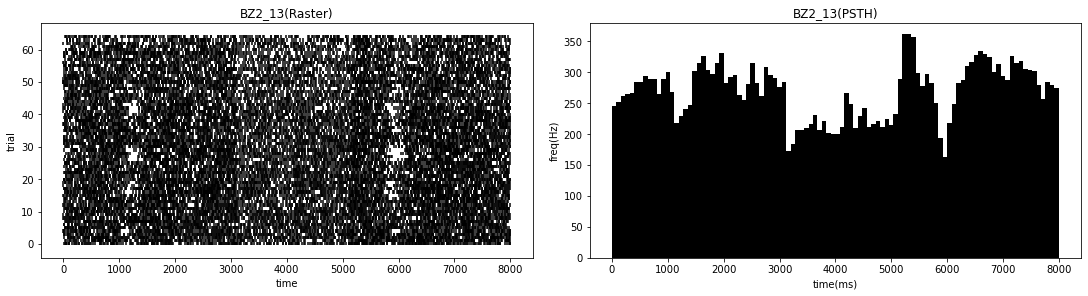

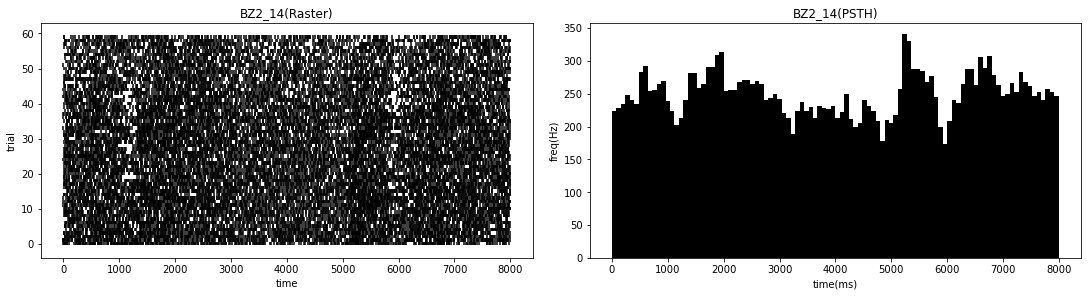

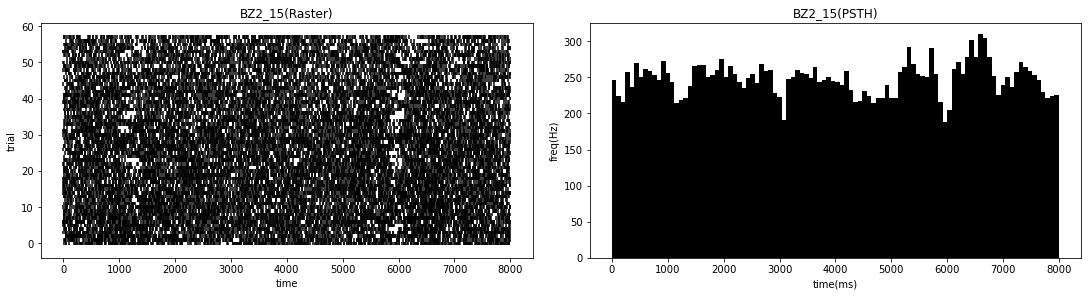

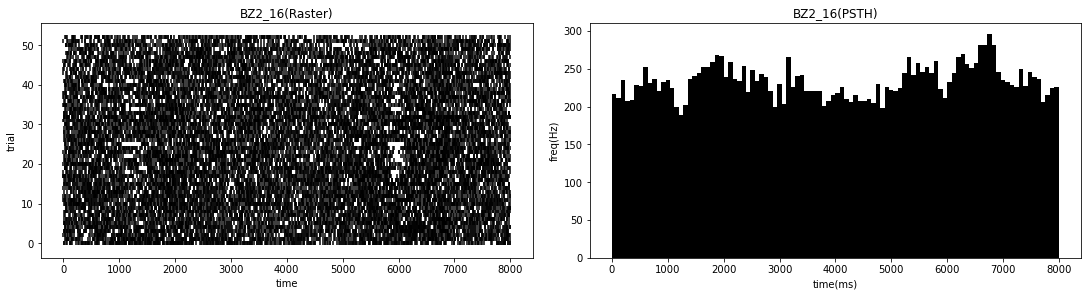

BZ3


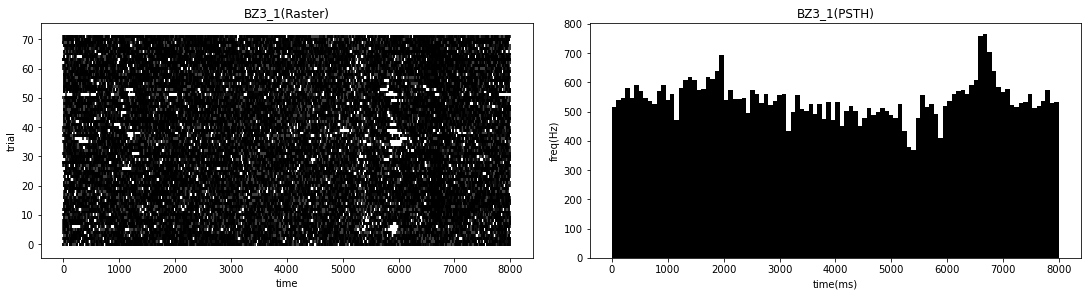

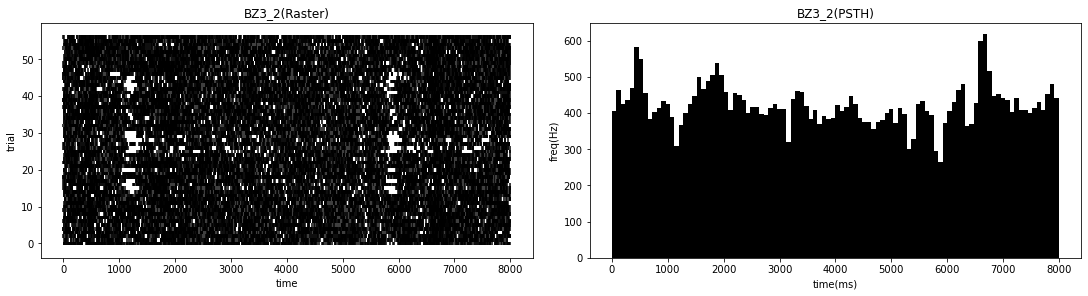

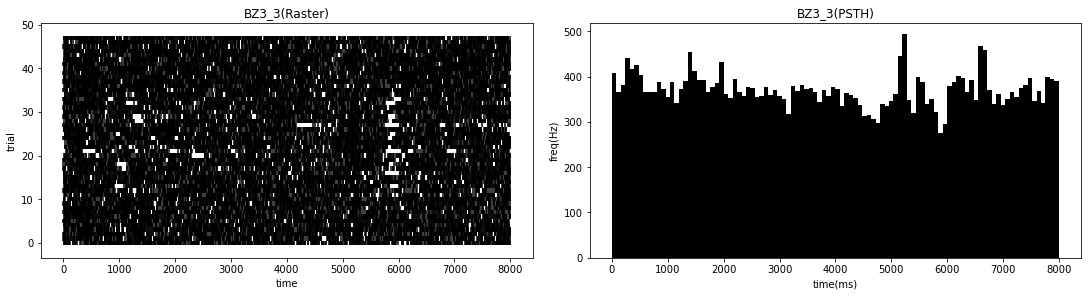

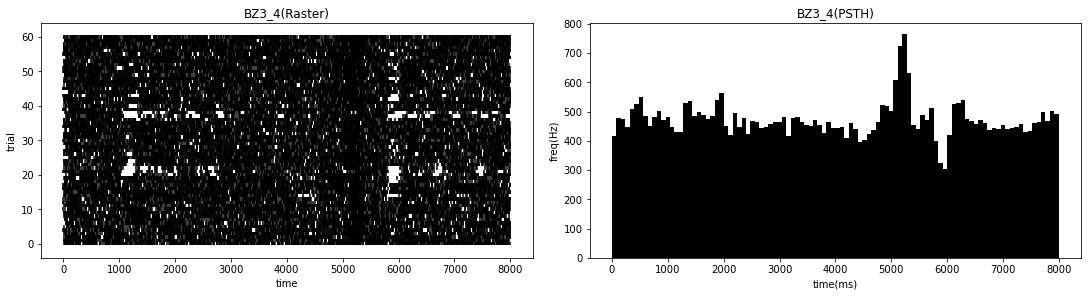

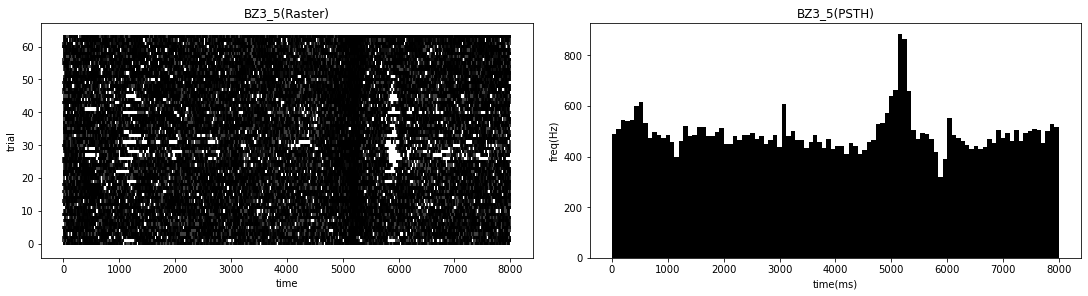

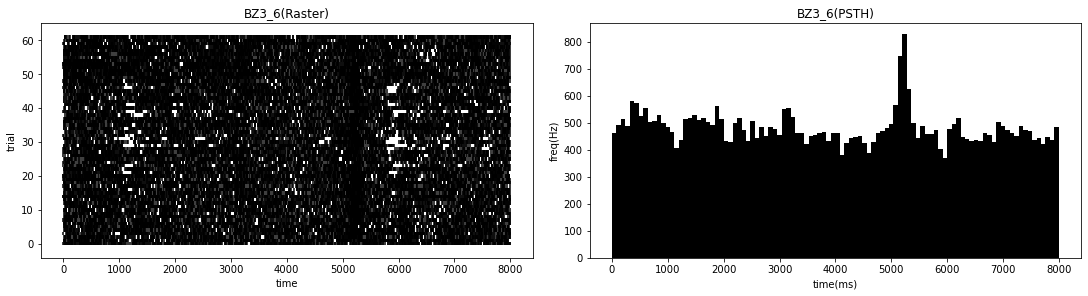

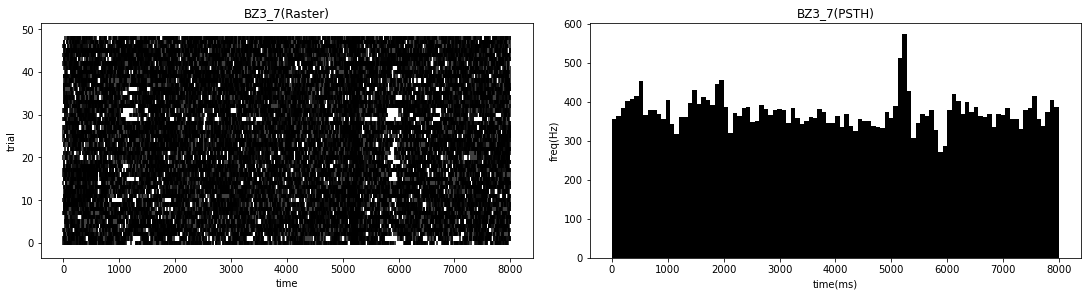

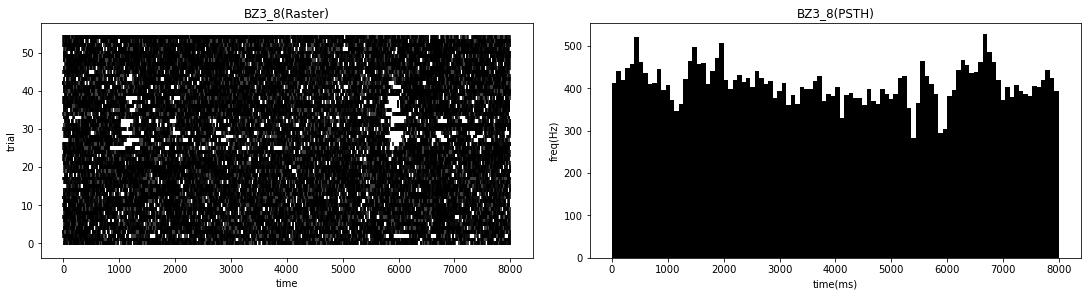

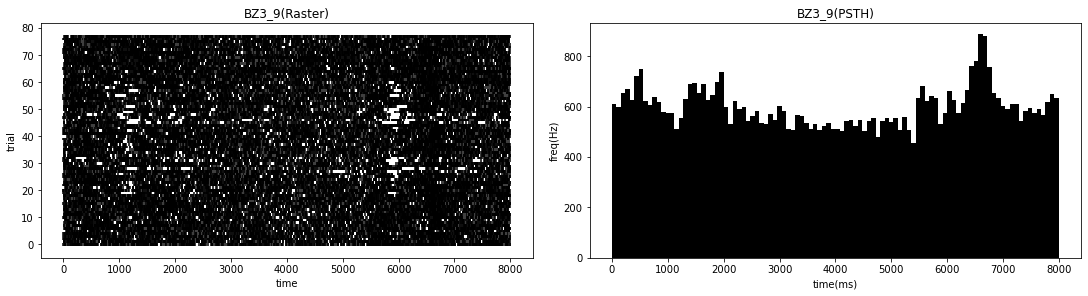

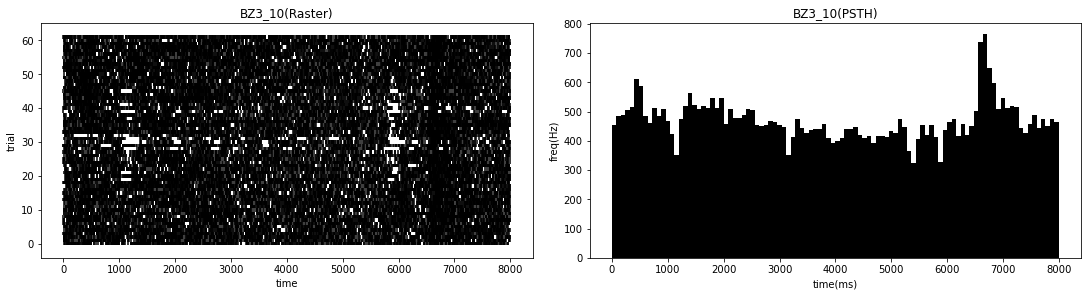

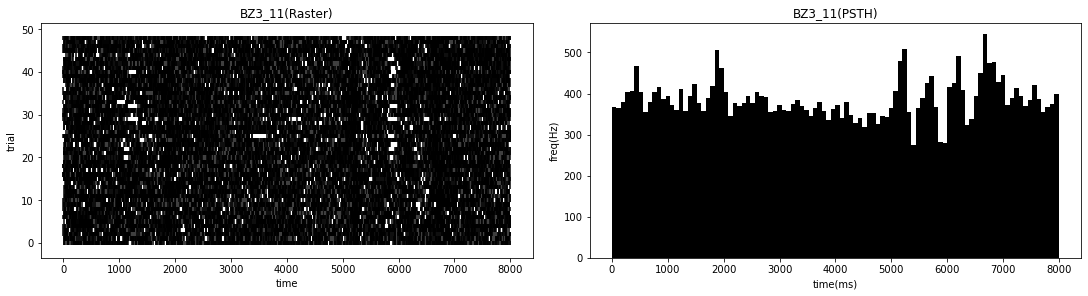

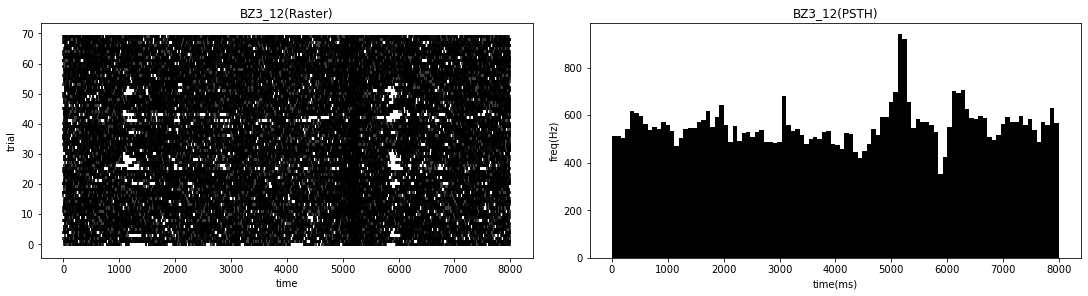

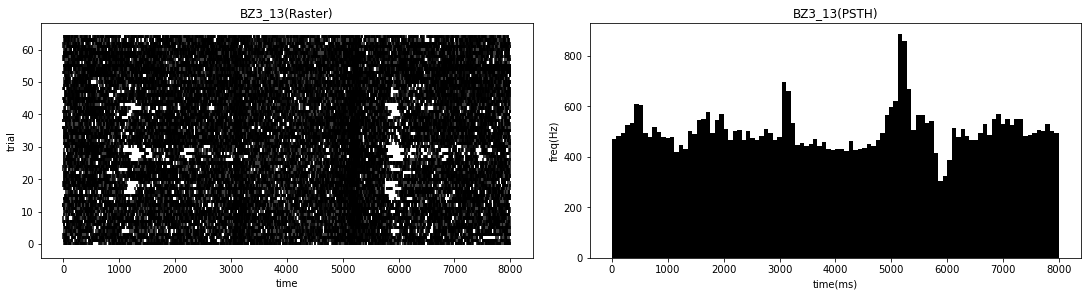

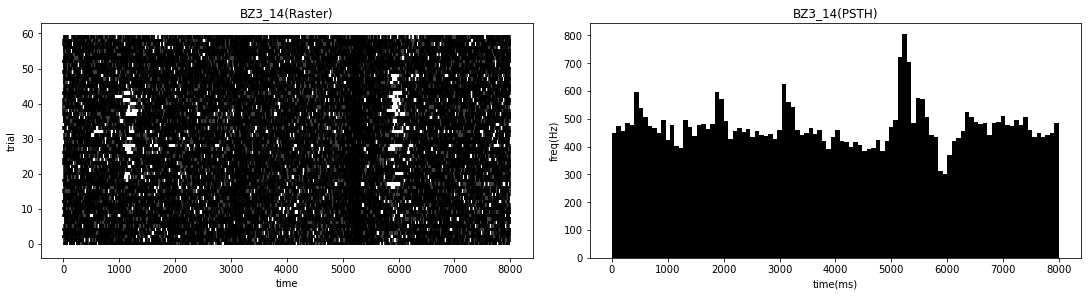

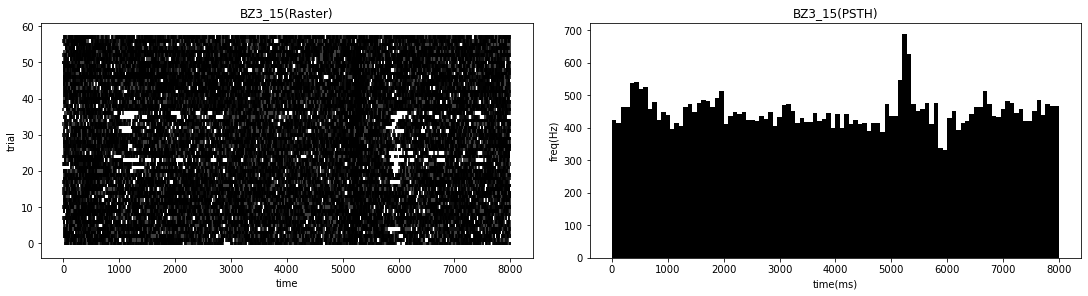

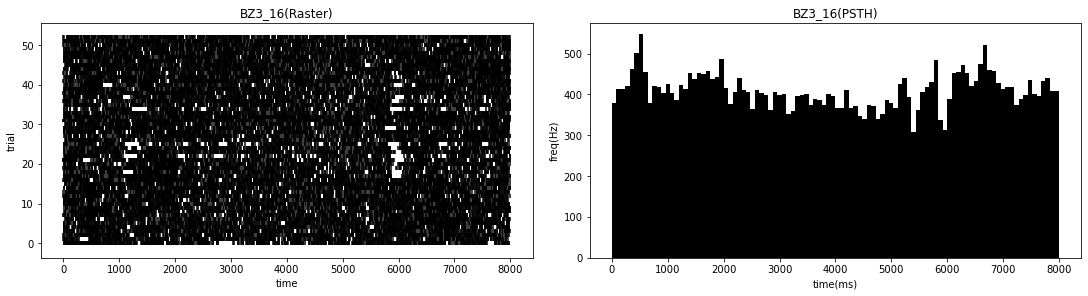

BZ5


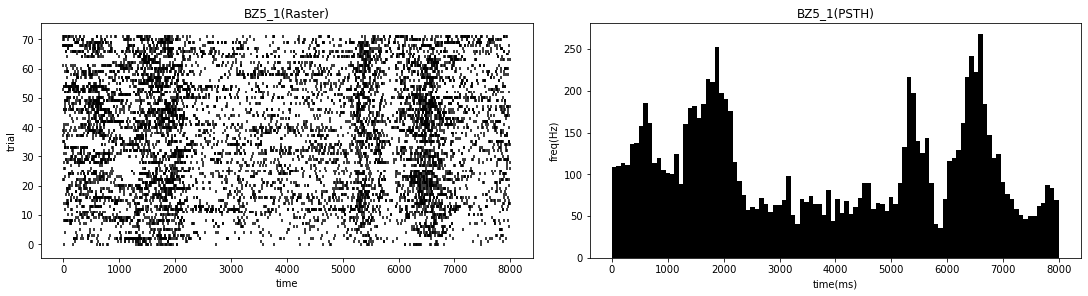

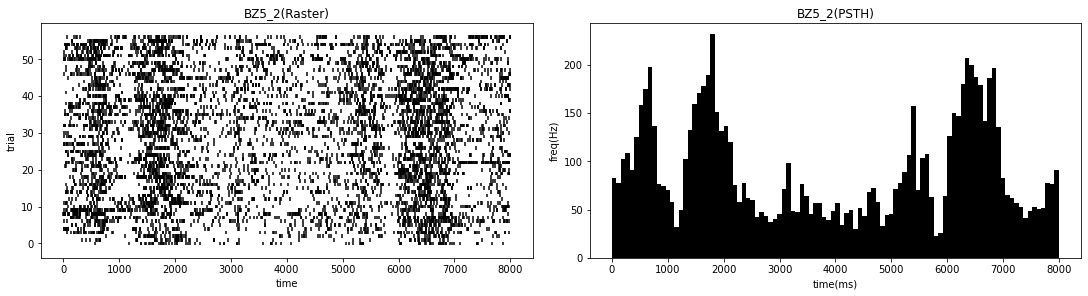

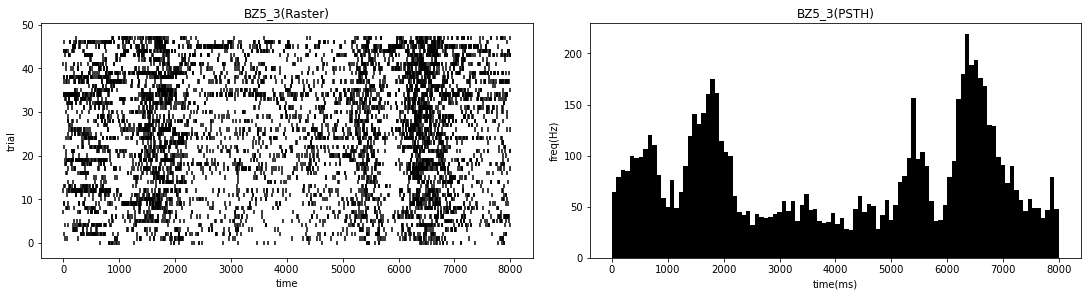

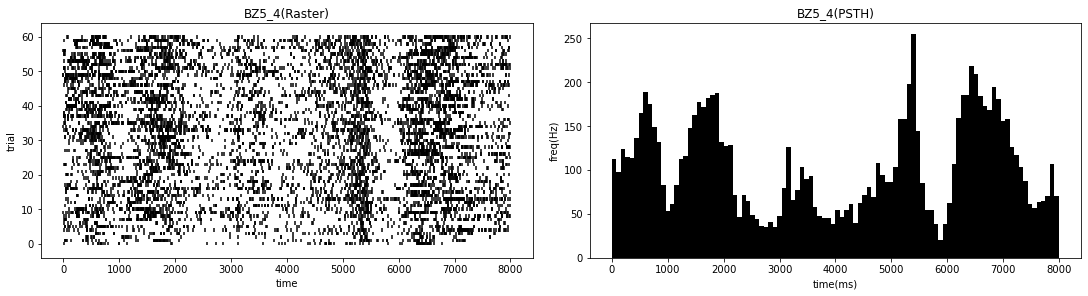

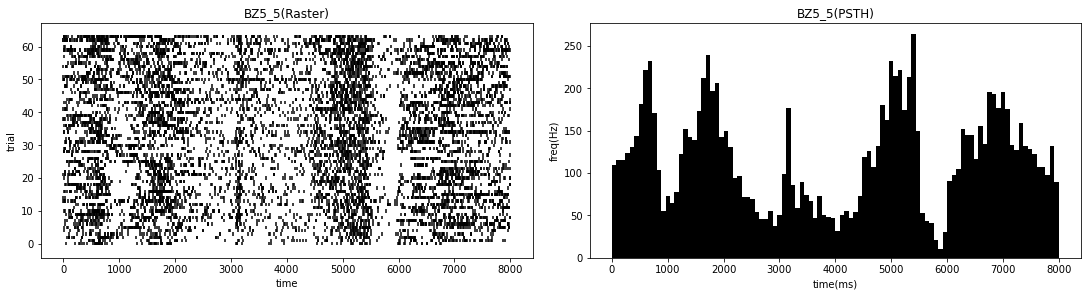

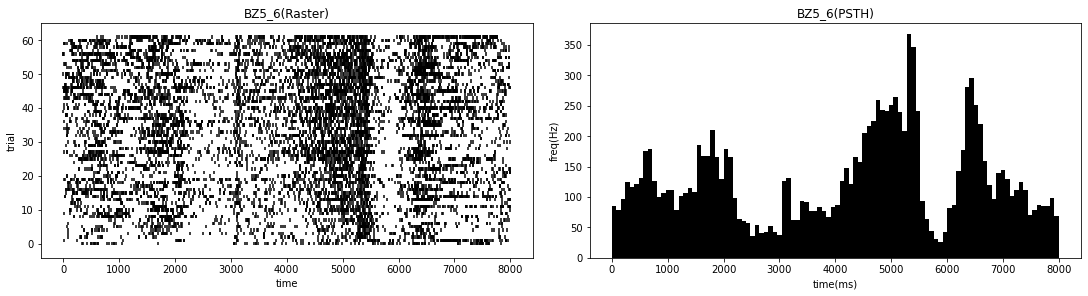

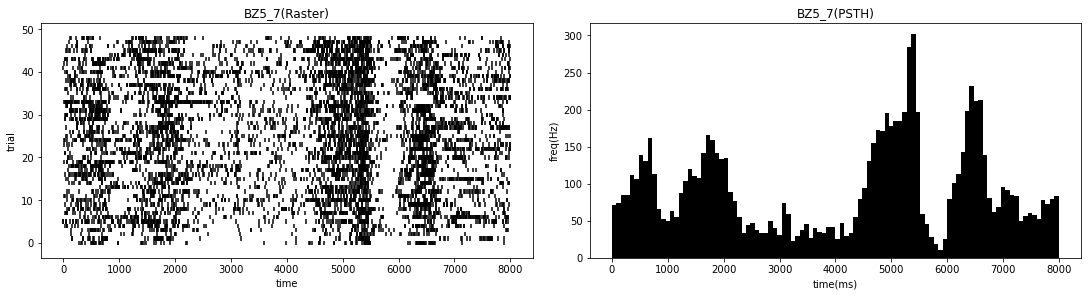

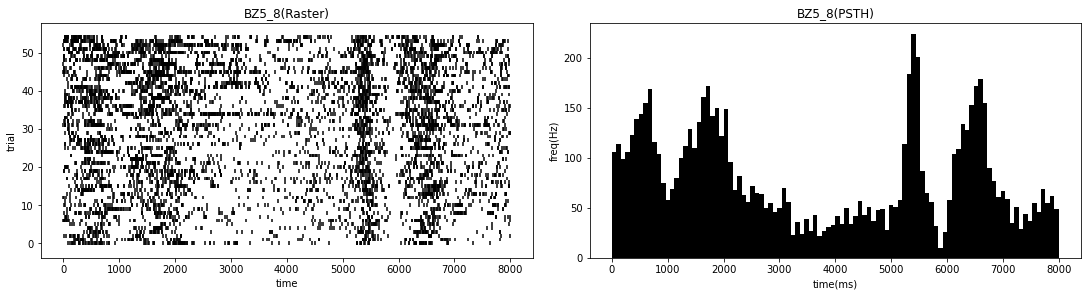

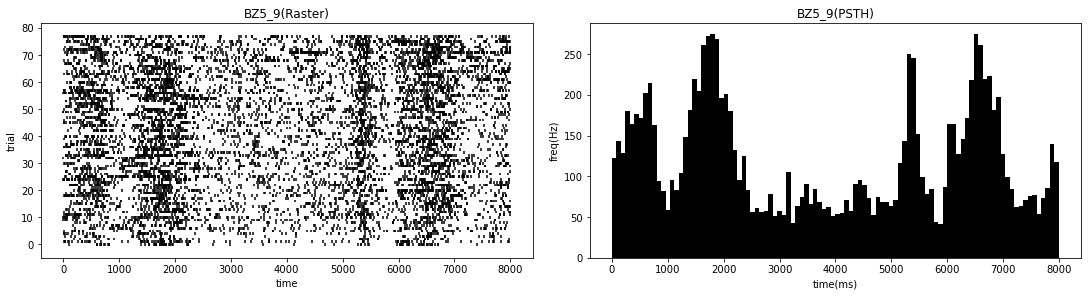

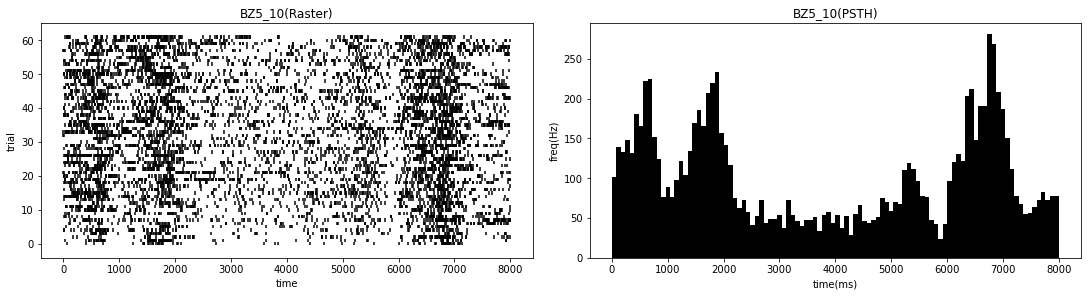

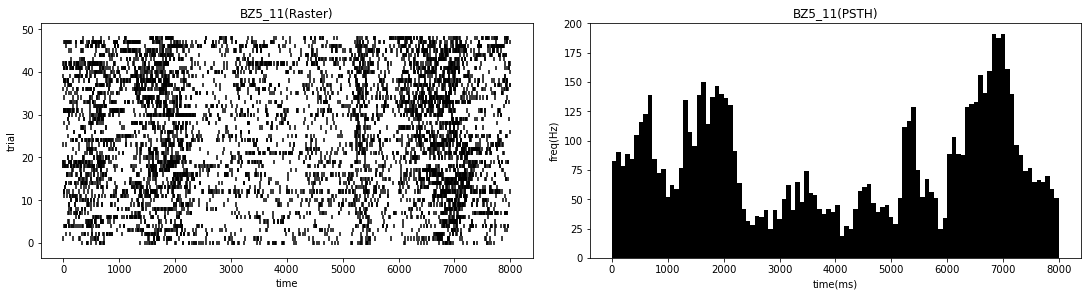

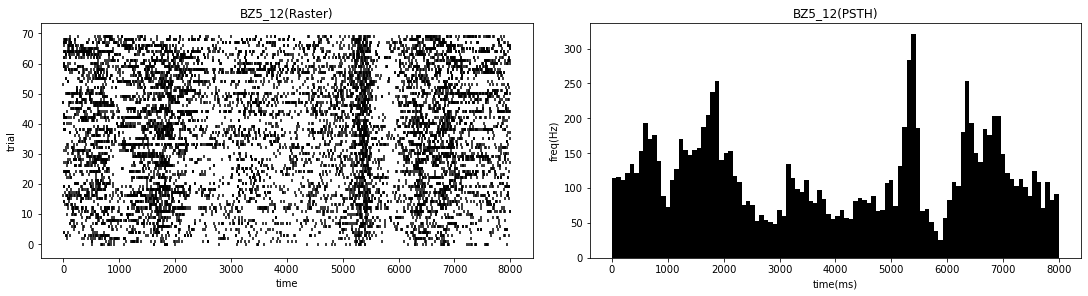

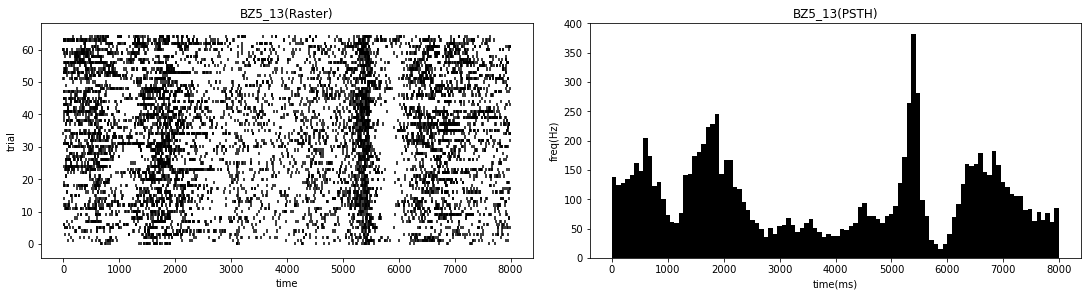

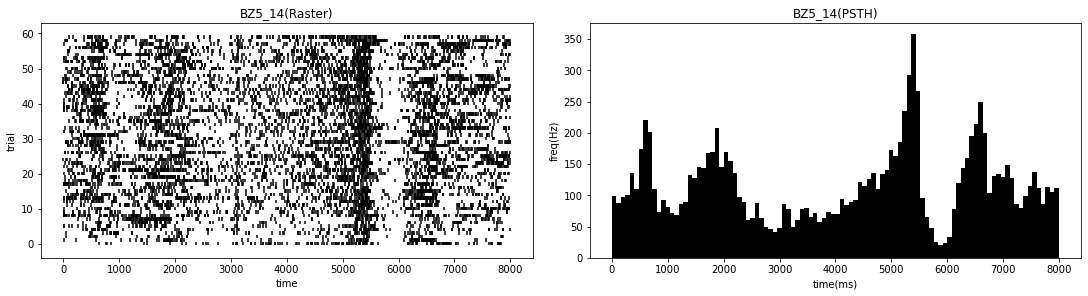

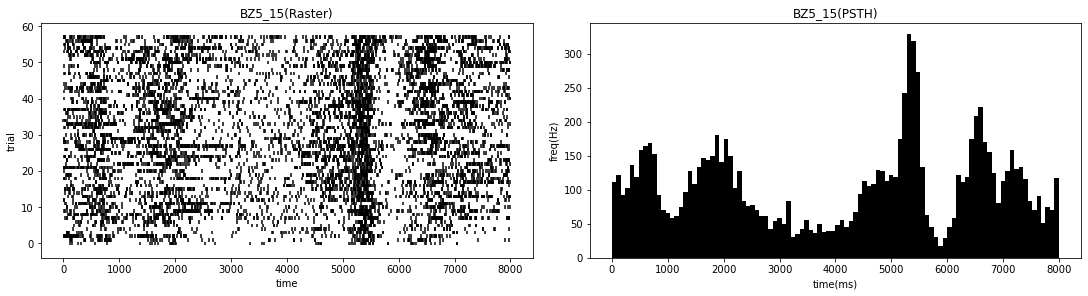

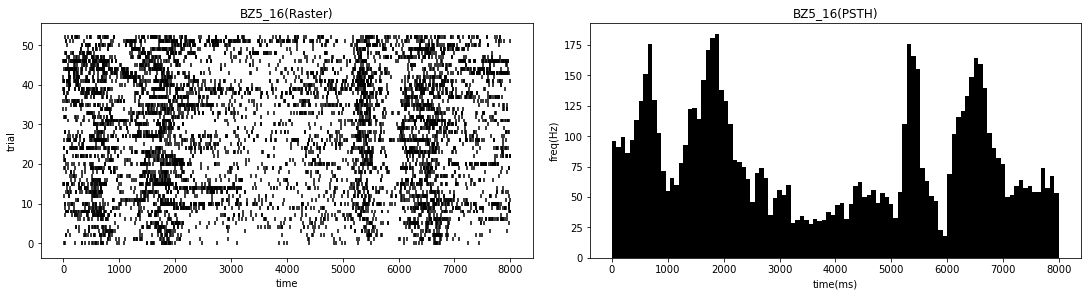

BZ8


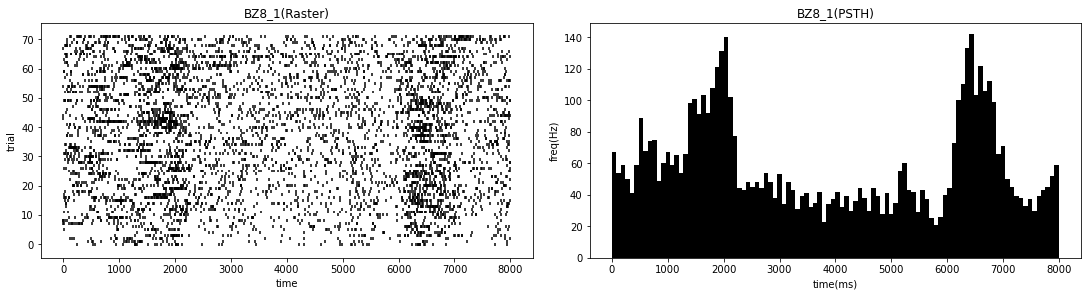

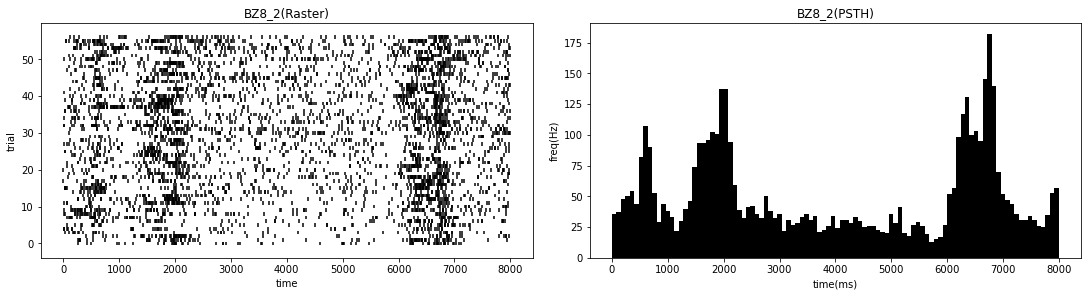

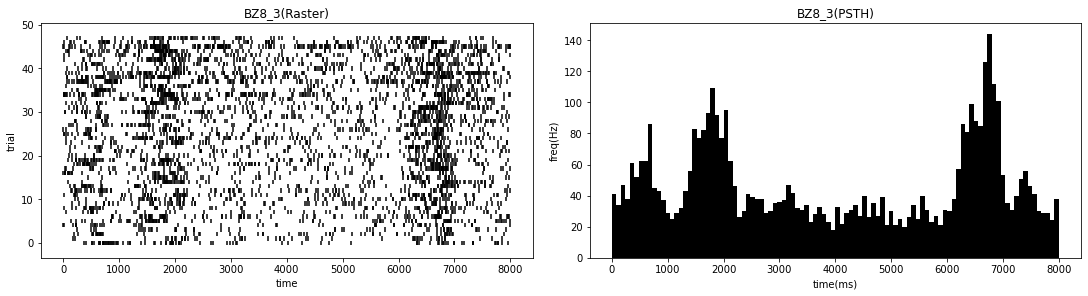

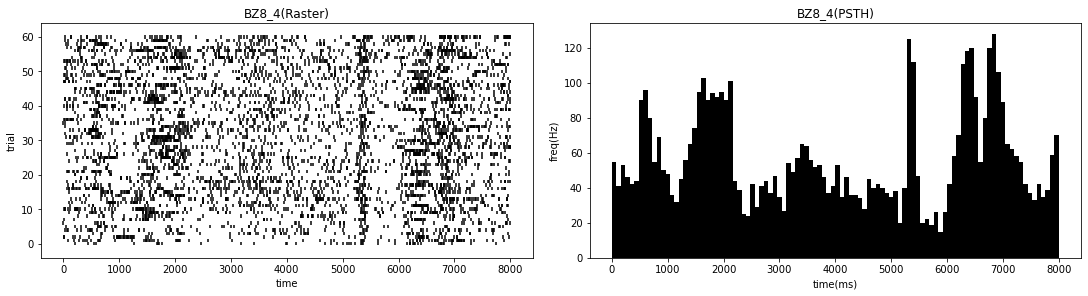

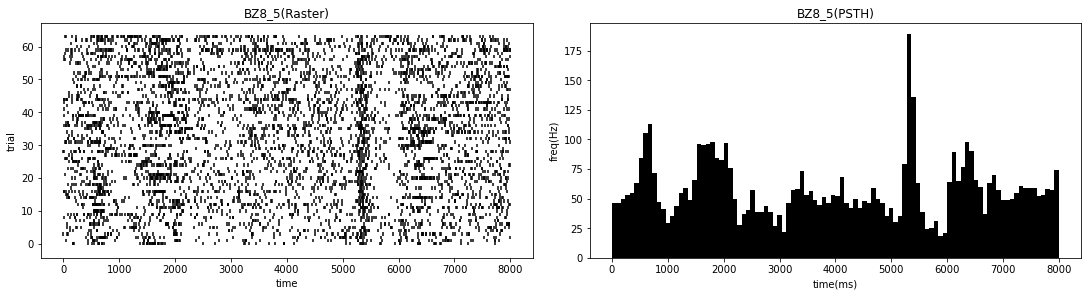

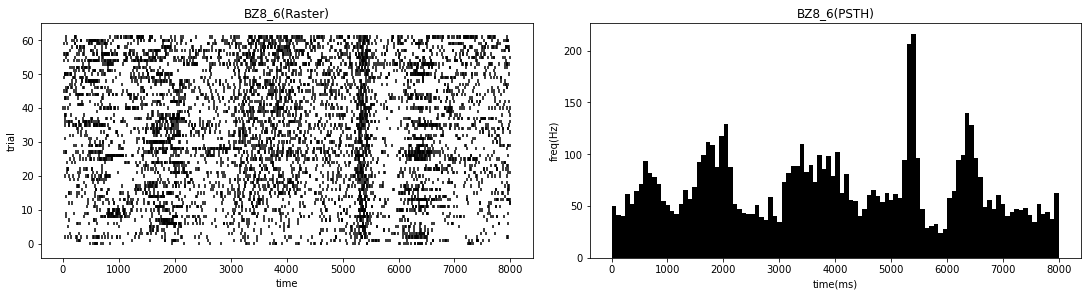

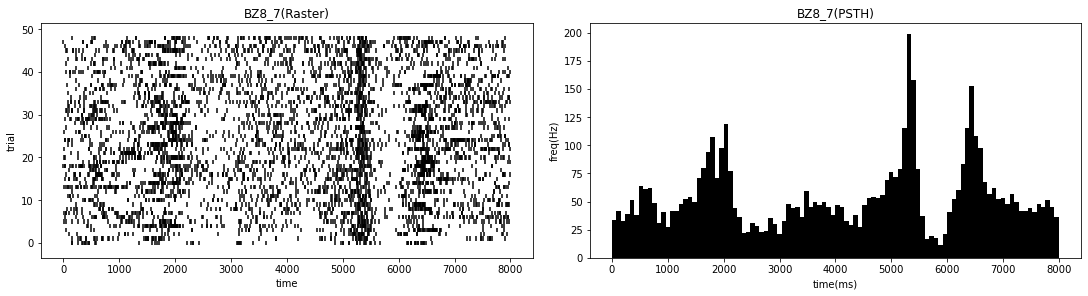

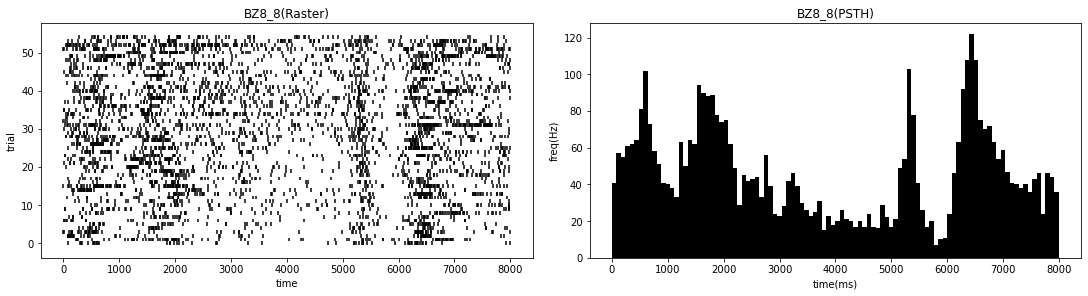

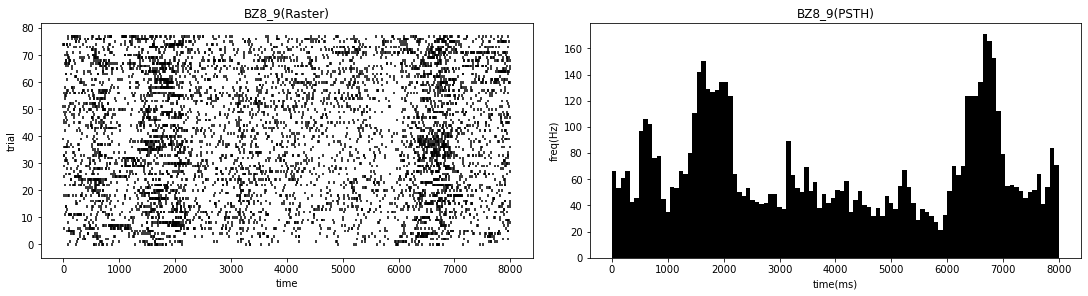

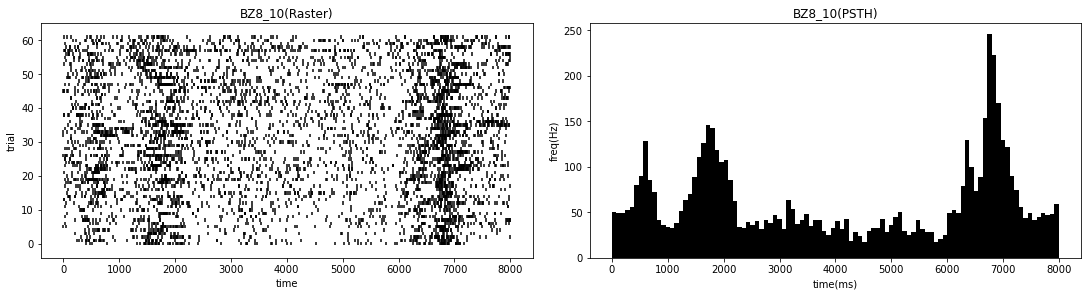

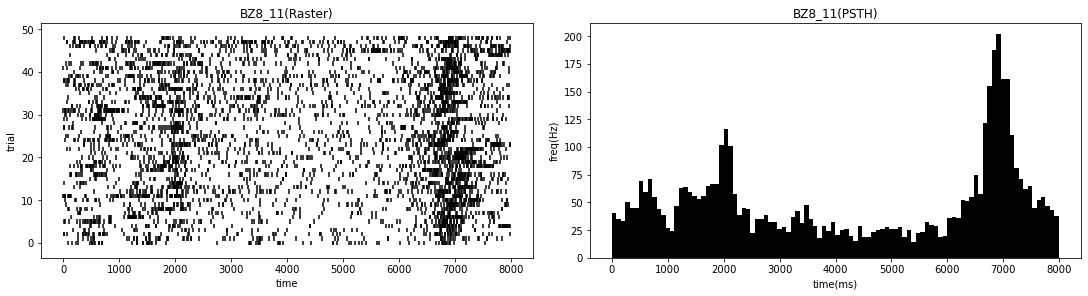

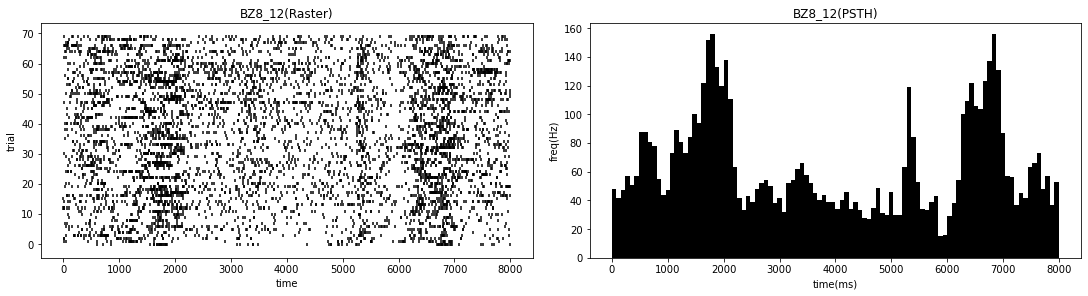

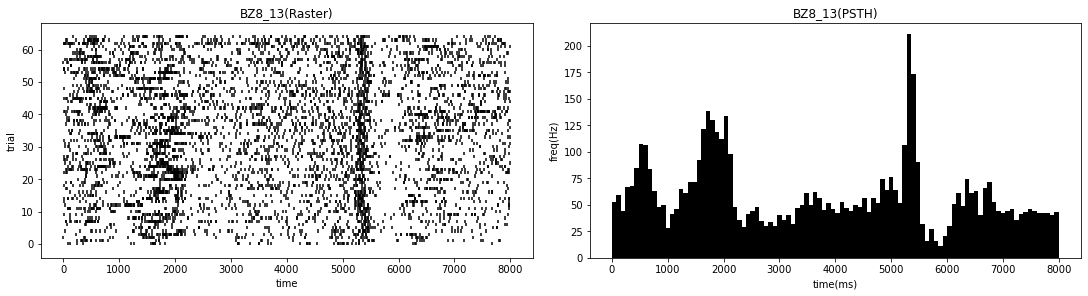

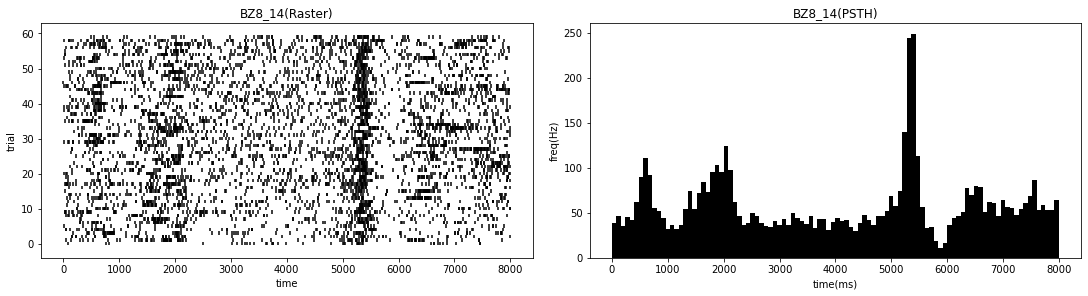

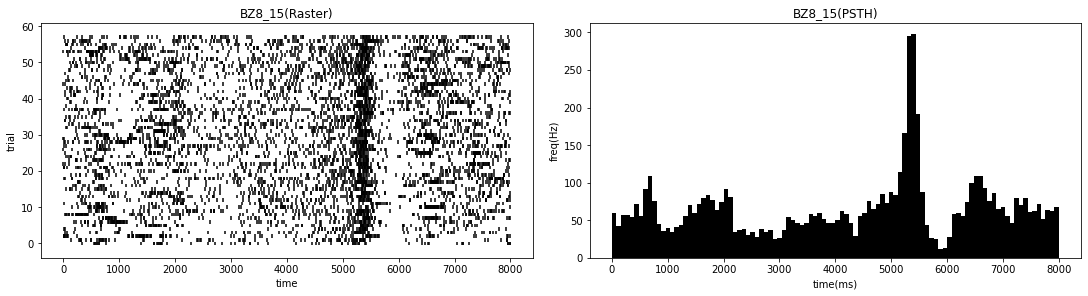

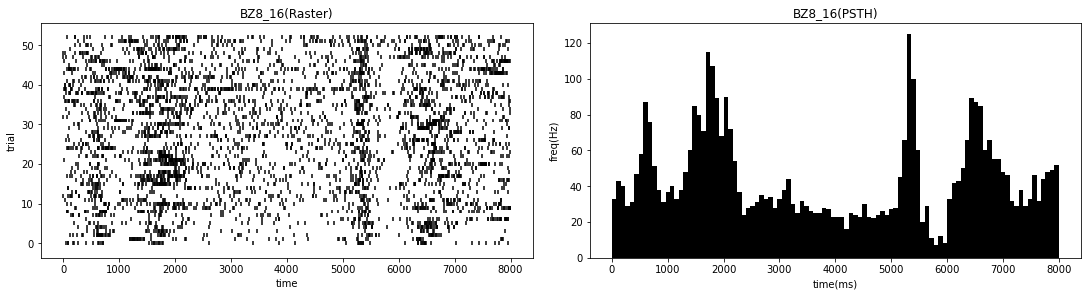

BZ9


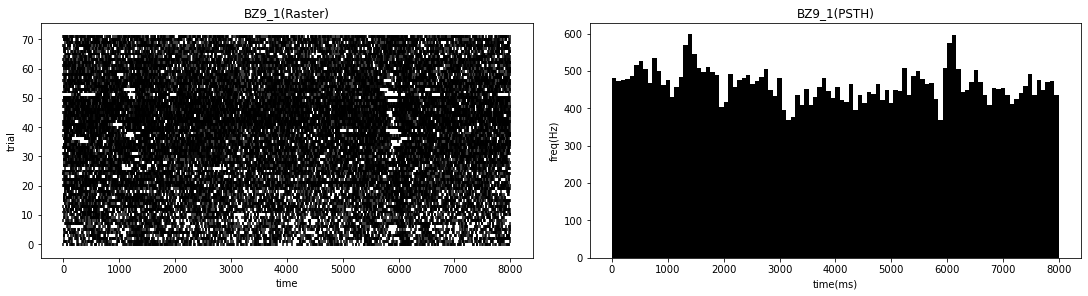

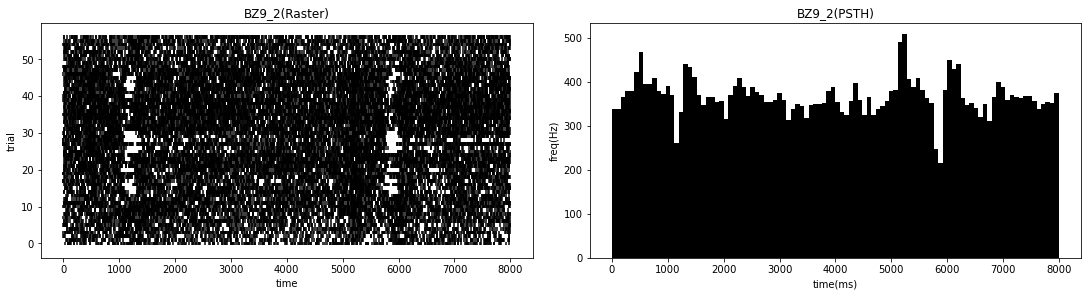

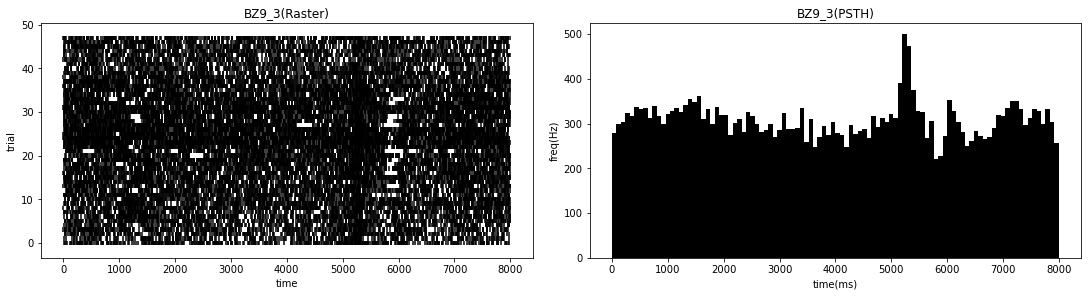

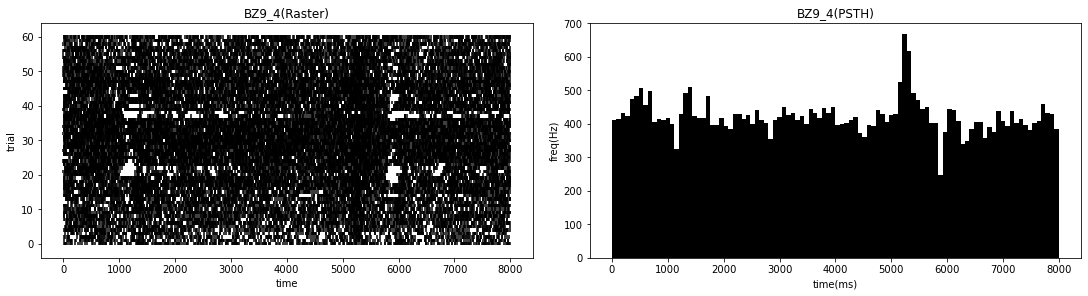

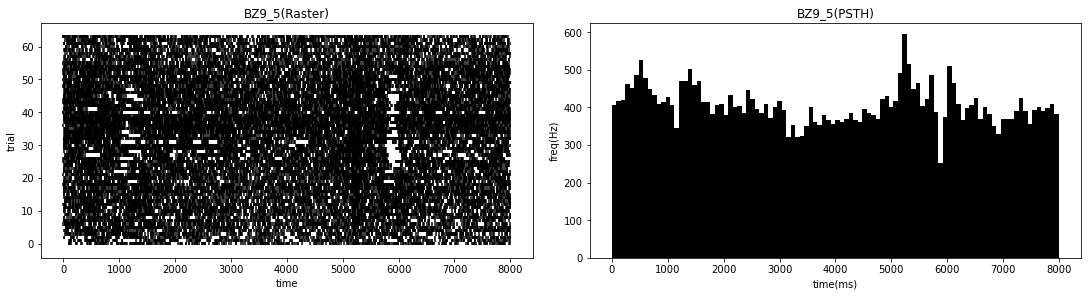

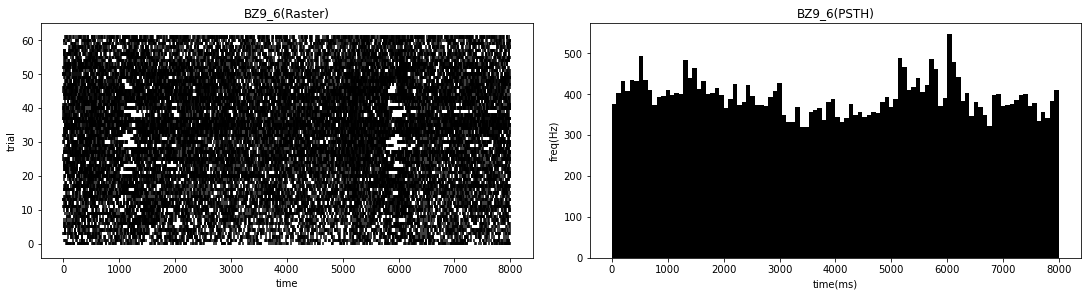

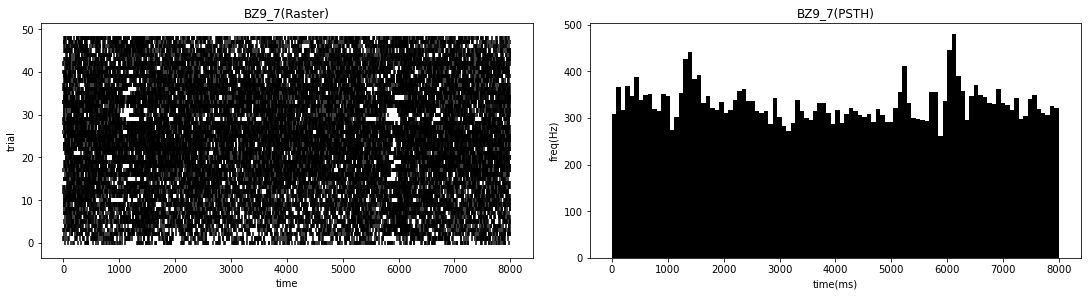

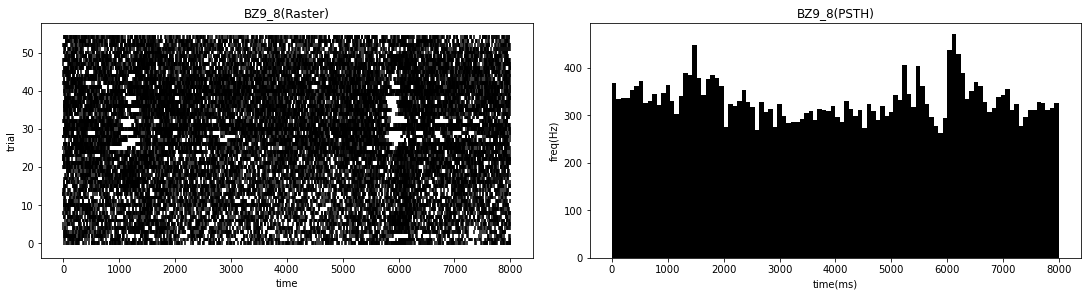

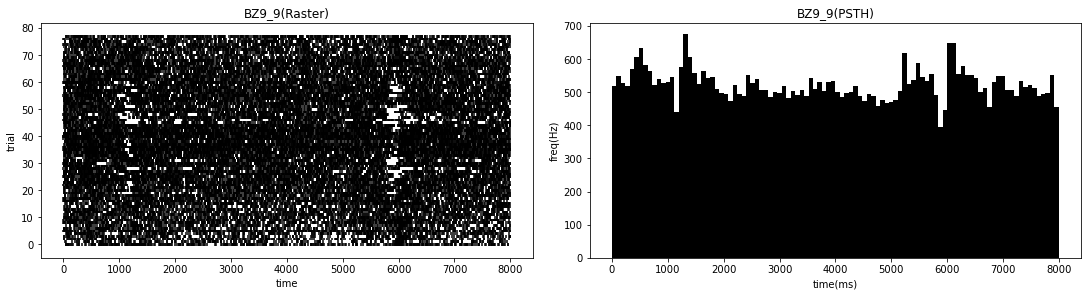

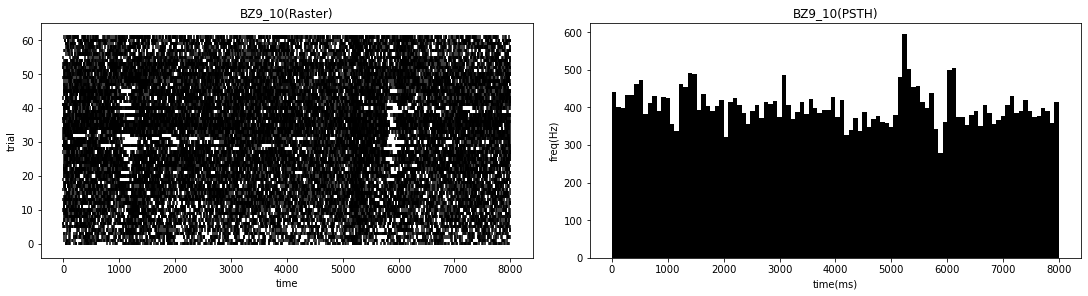

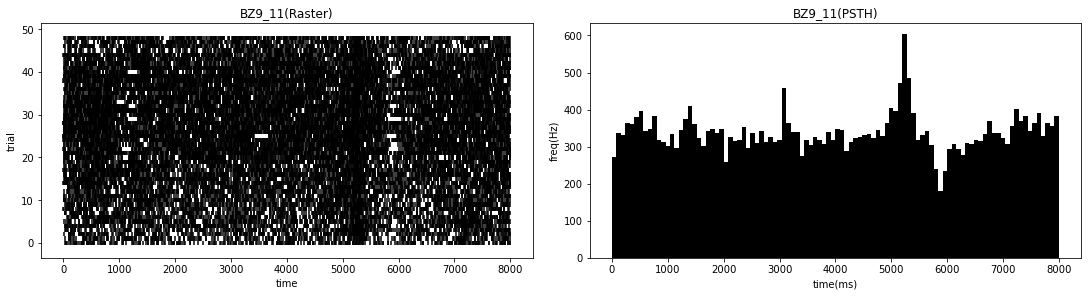

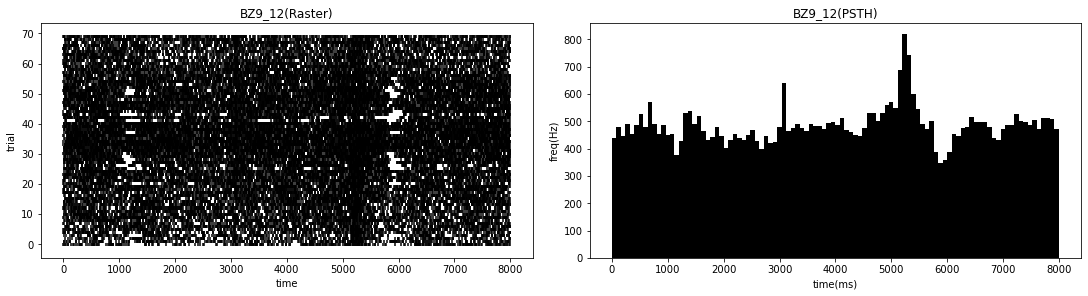

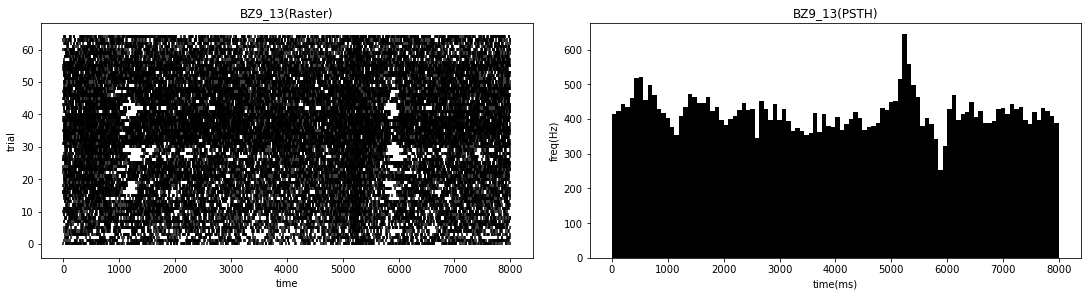

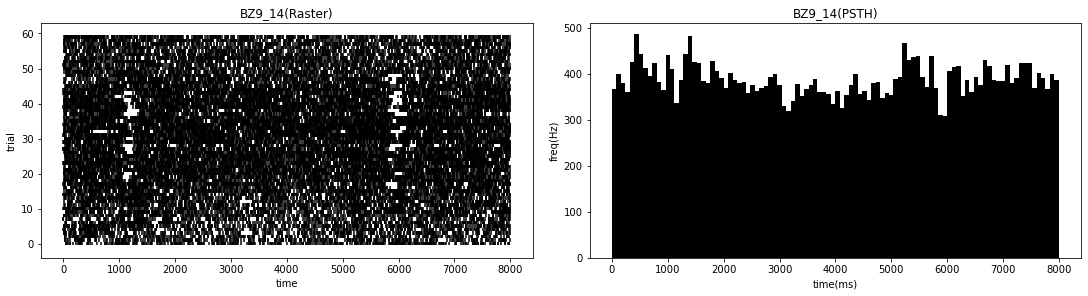

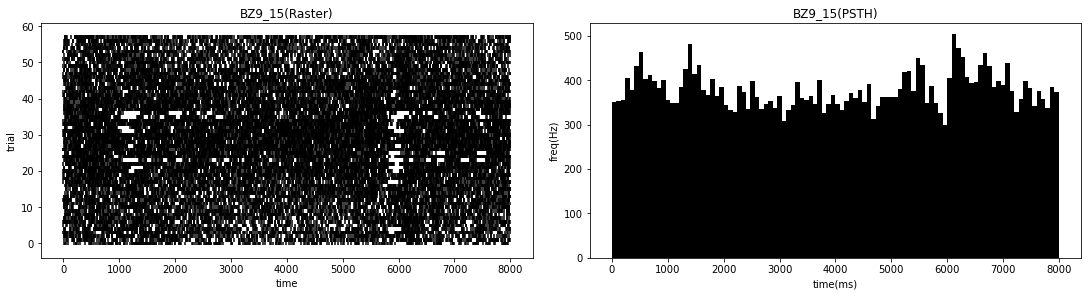

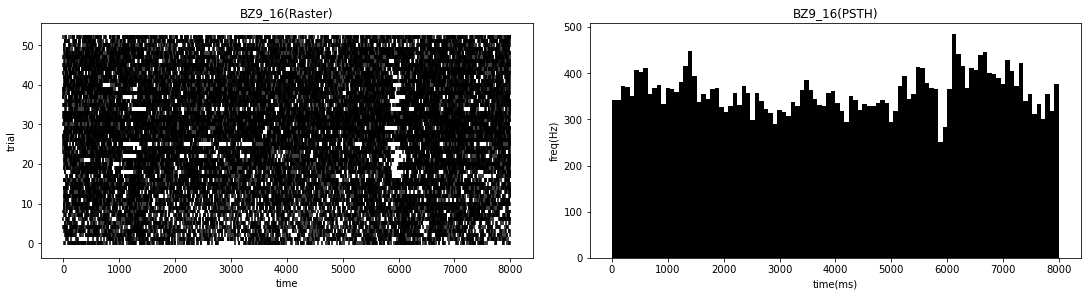

BZ11


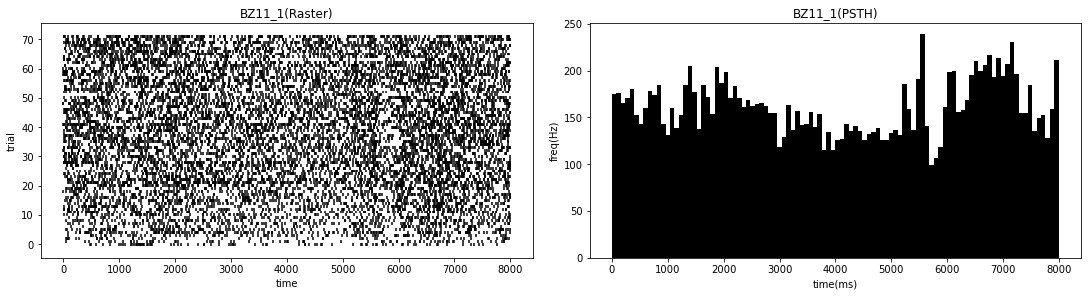

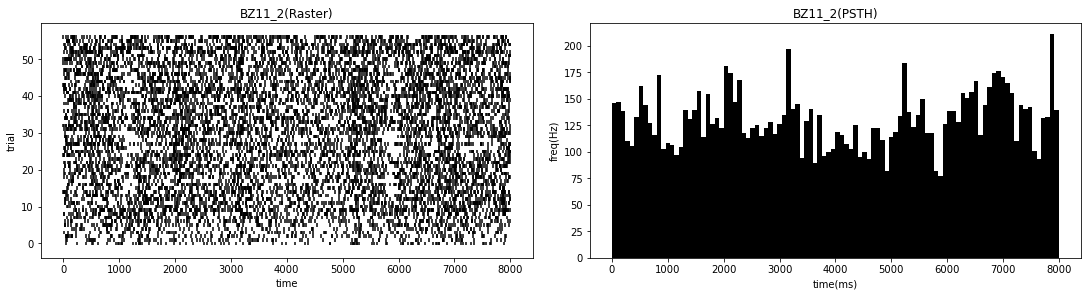

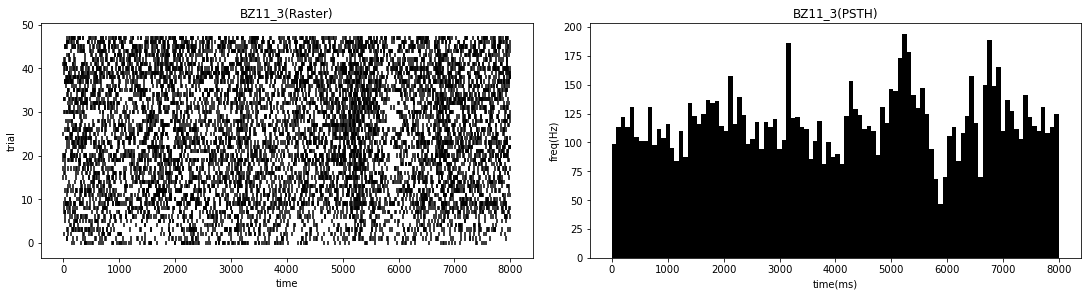

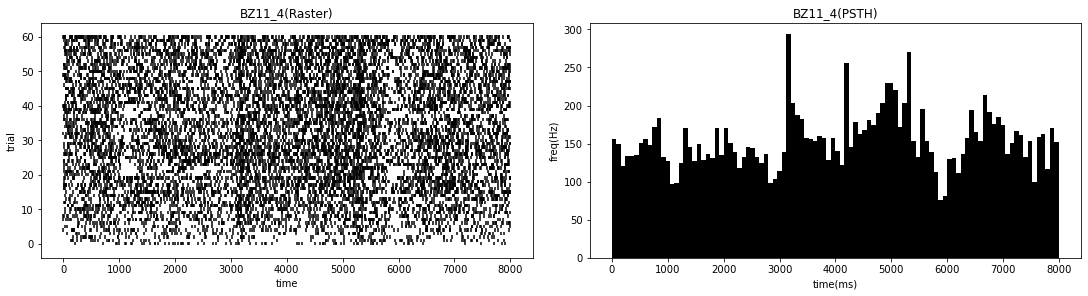

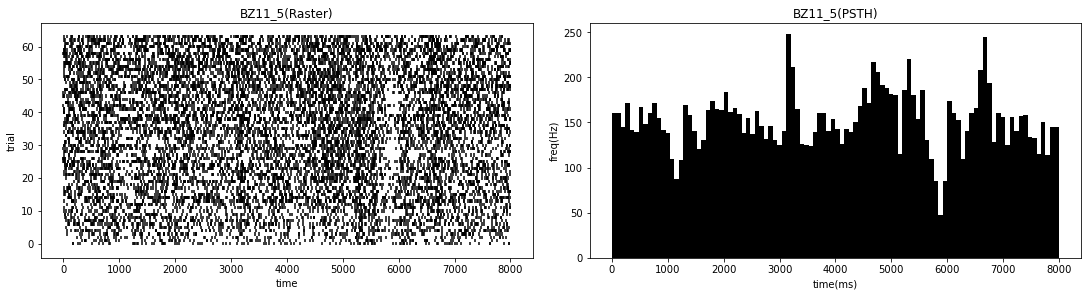

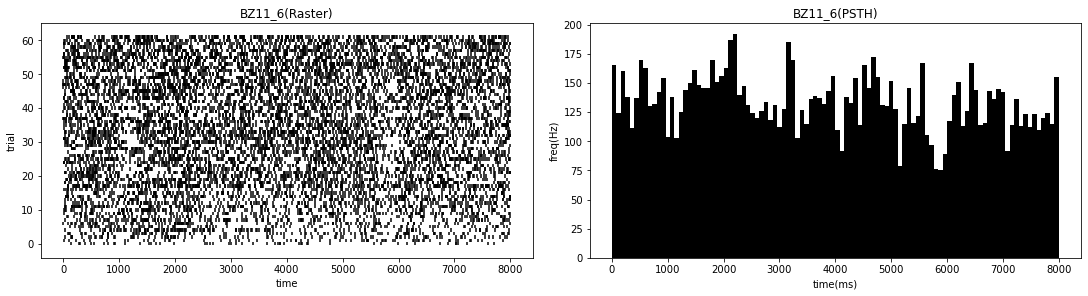

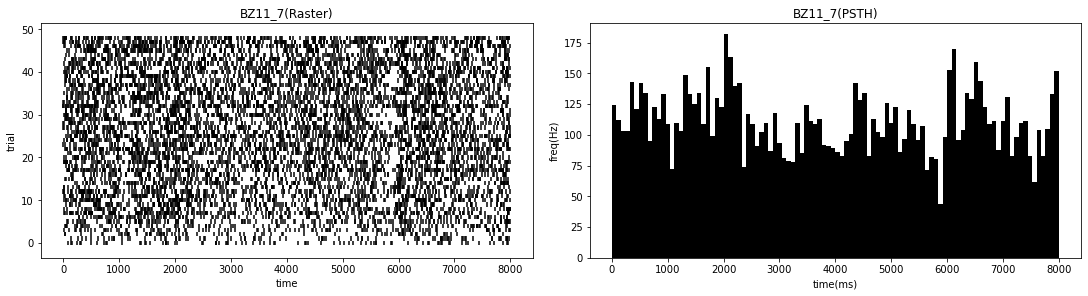

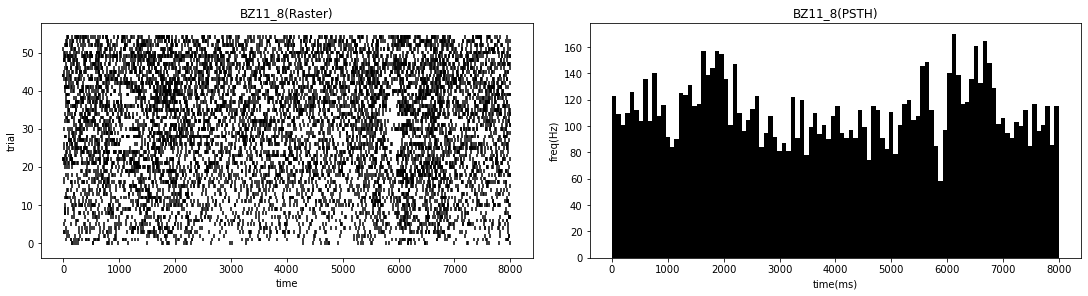

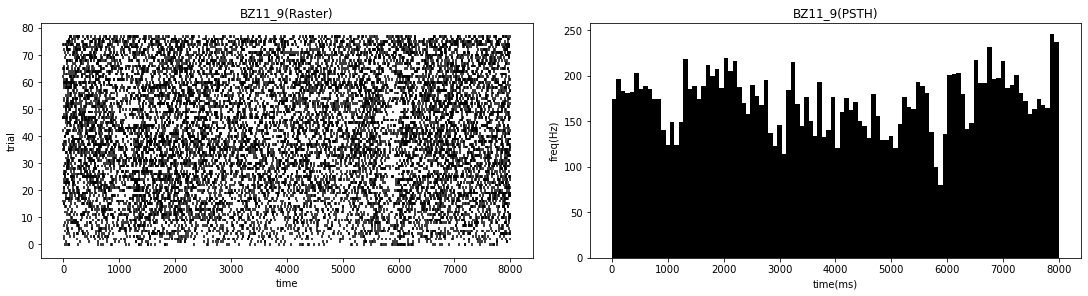

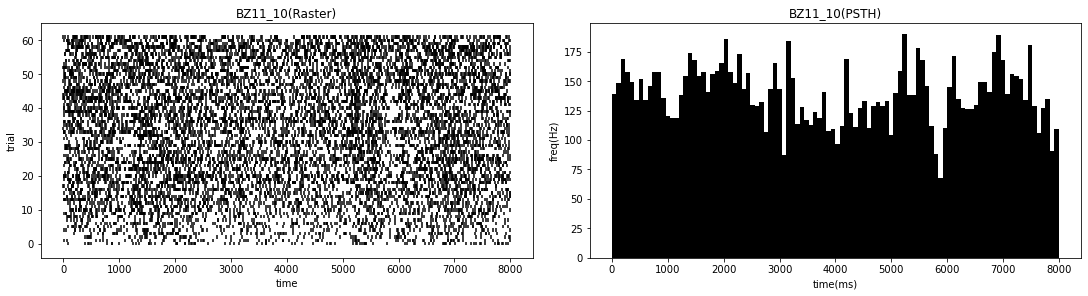

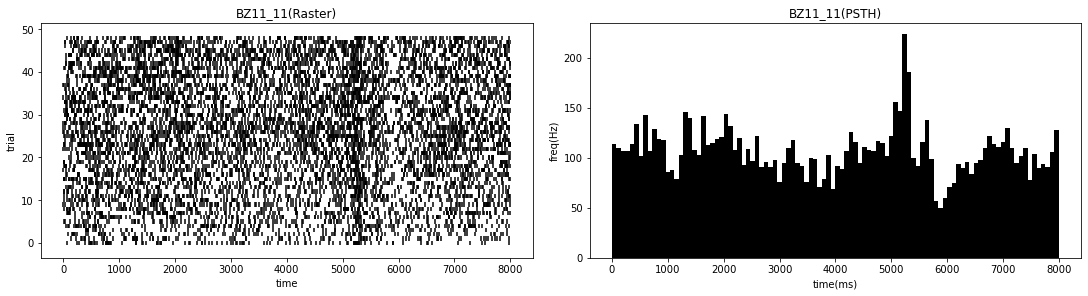

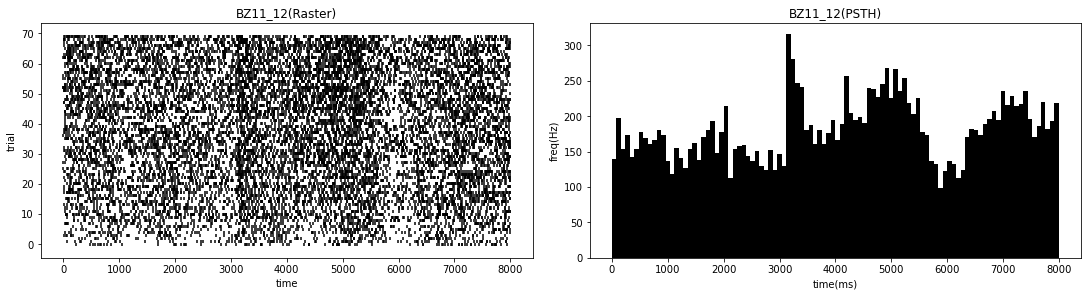

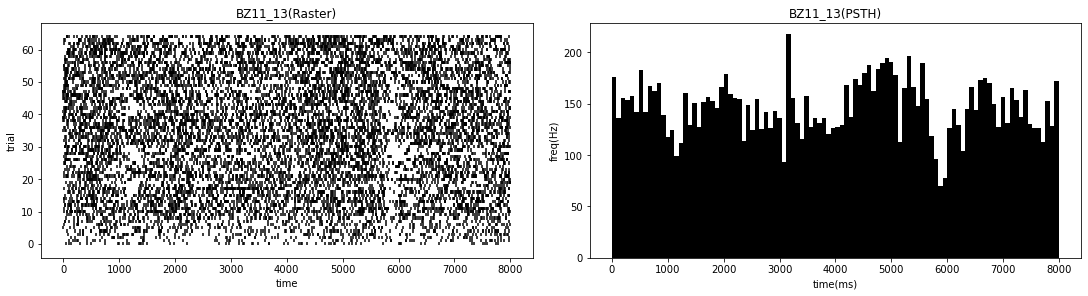

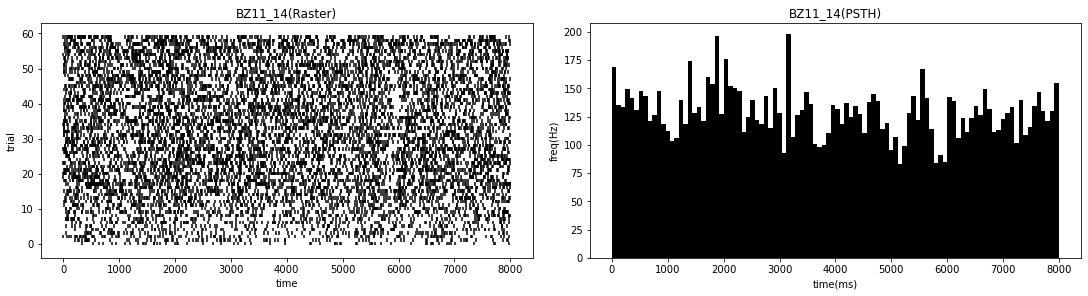

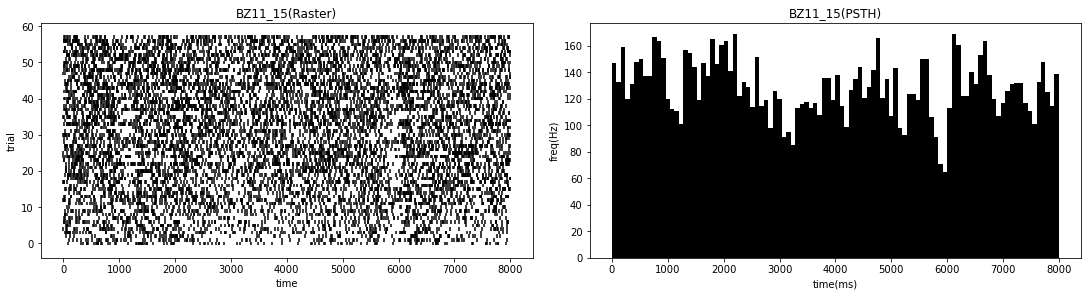

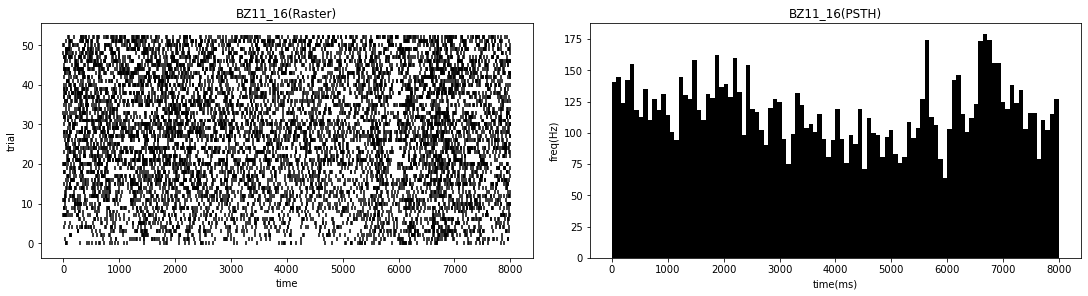

BZ13


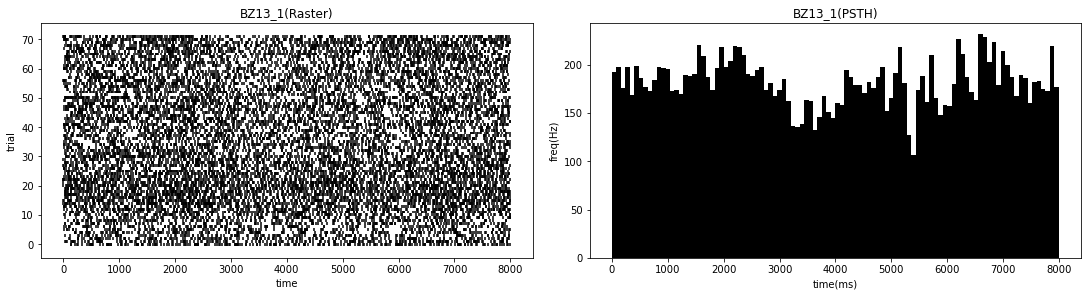

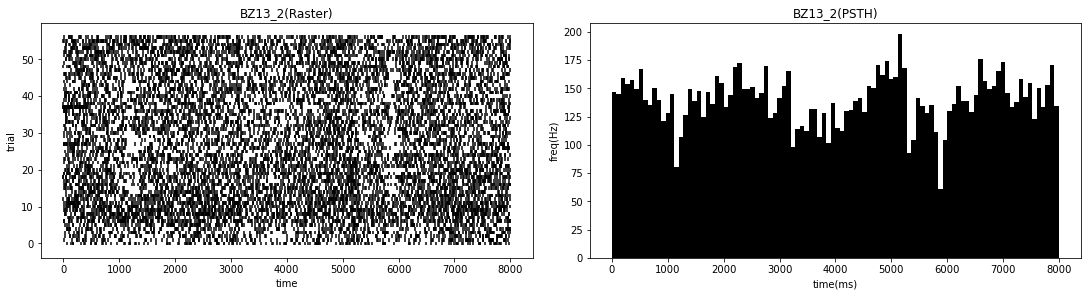

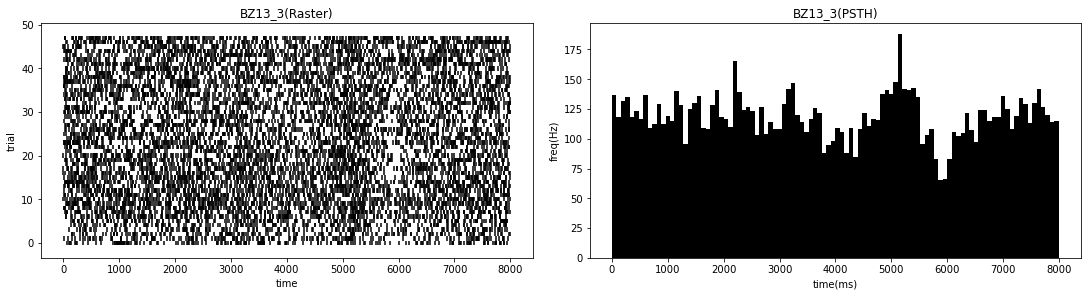

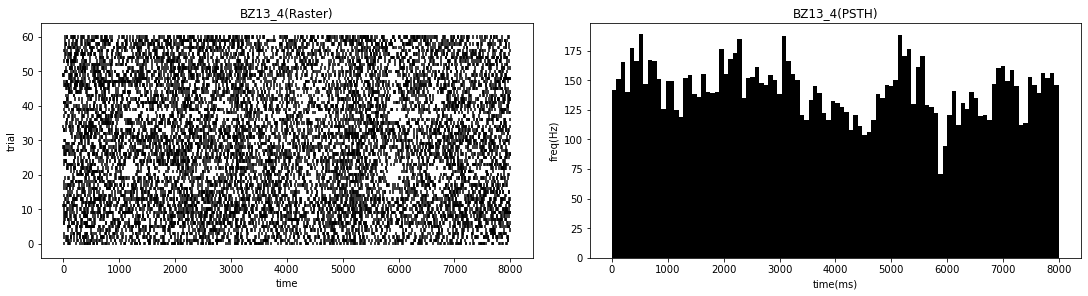

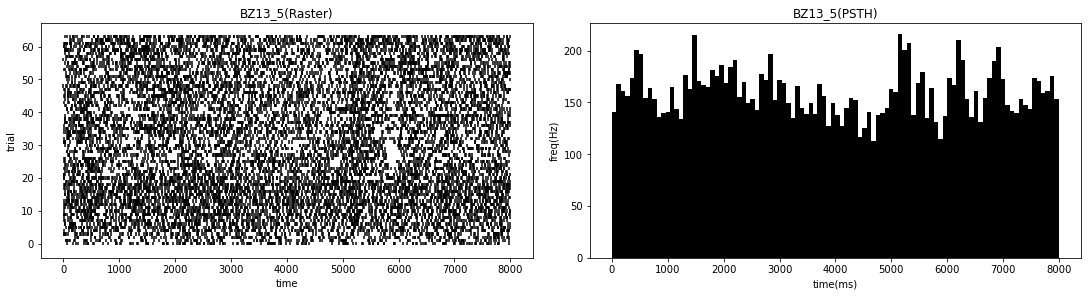

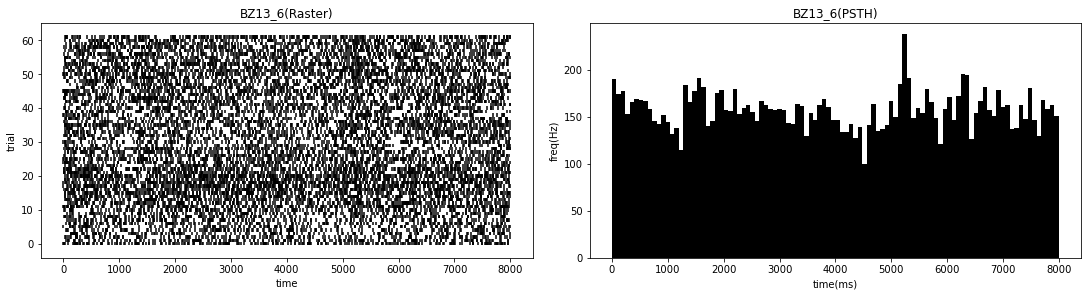

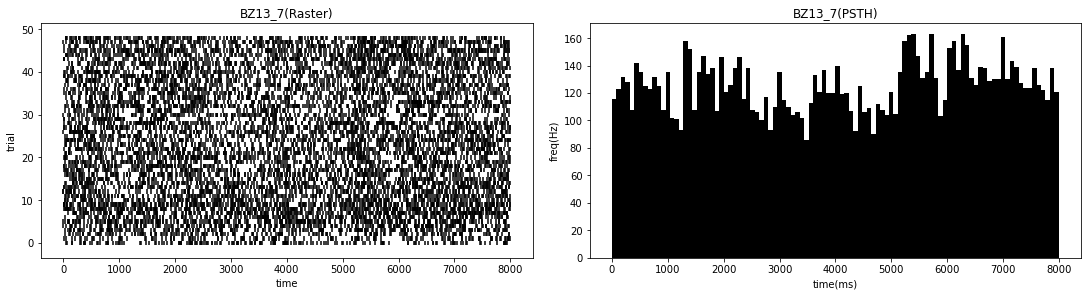

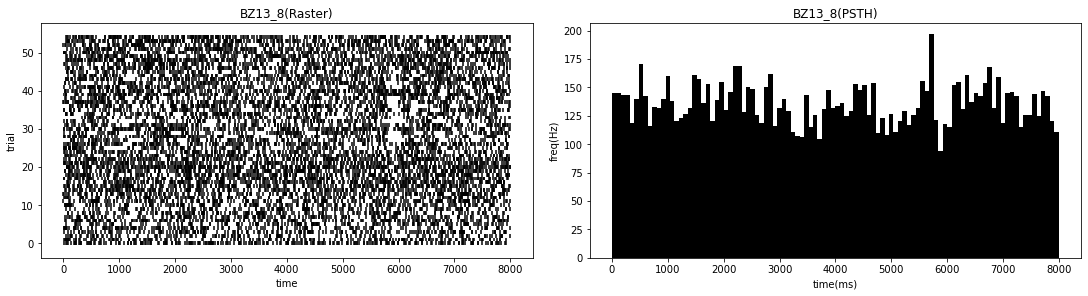

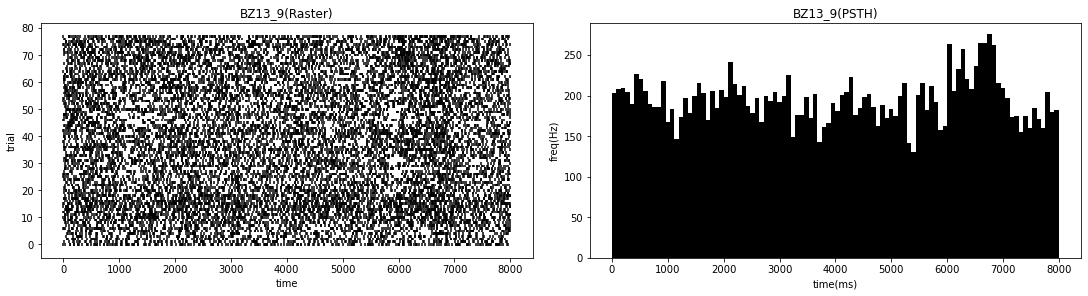

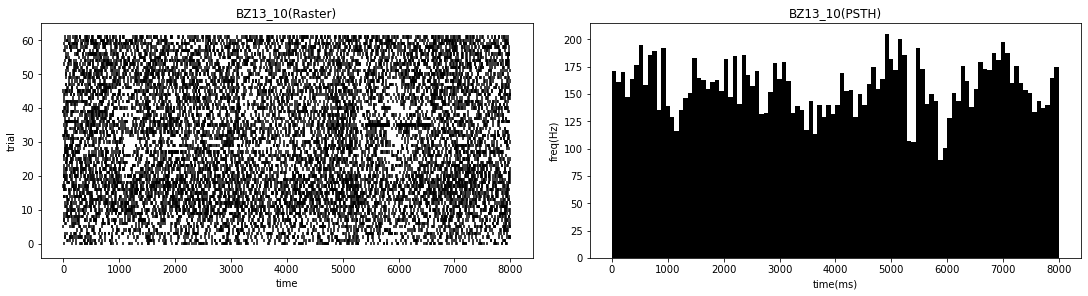

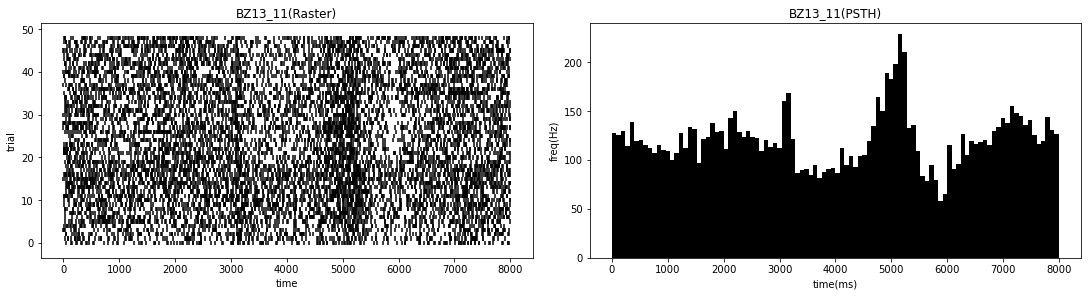

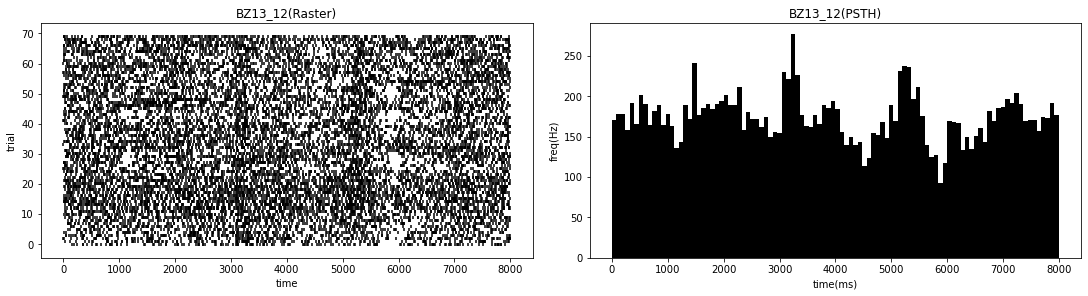

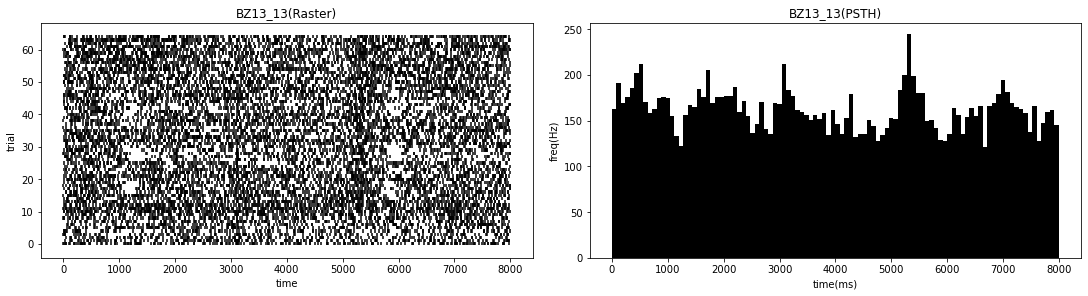

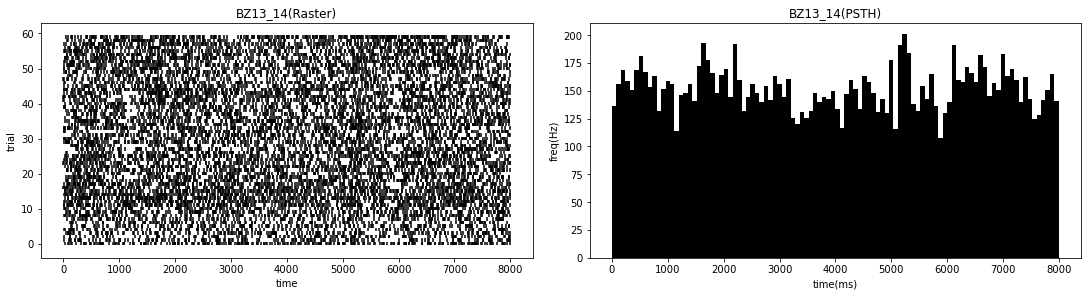

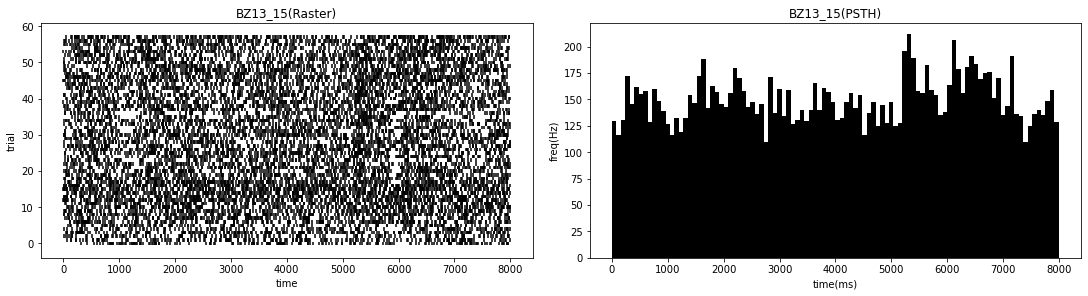

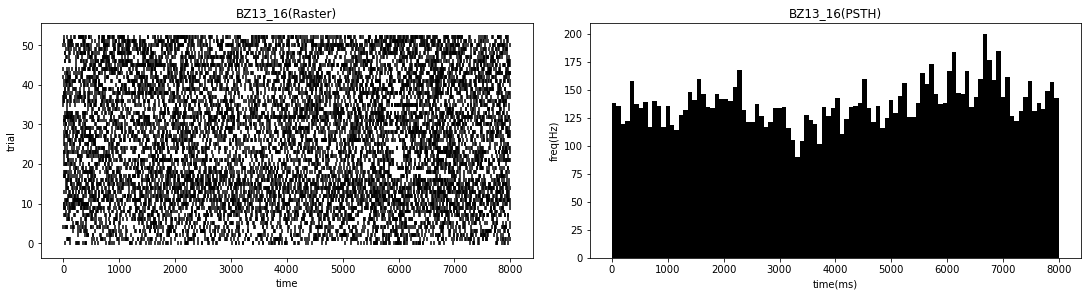

In [37]:
def get_stim_spike_train(data,stim_num):
    stim_spike = []
    for trial in stim_dict[stim_num]:
        stim_spike.append(list(data[trial]))
    stim_spike = np.array(stim_spike)
    return stim_spike

valid_channels = [1,2,3,5,8,9,11,13]
file_names = ['dataset/SpikeActBZ'+str(i) for i in valid_channels]
for k,channel in enumerate(valid_channels):
    file_name = file_names[k]
    spike_data = scipy.io.loadmat(file_name)['su'][0][0]
    print('BZ'+str(channel))
    for stim_num in range(1,17):
        figure, axis = plt.subplots(1,2,figsize=(15,4),constrained_layout = True)     
        data = get_stim_spike_train(spike_data,stim_num)
        data = [(np.where(data[i] == 1)[0]) for i in range(len(data))]
        axis[0].eventplot(data,color='black')
        axis[0].set_xlabel('time')
        axis[0].set_ylabel('trial')
        axis[0].set_title('BZ'+str(channel)+"_"+str(stim_num)+"(Raster)")
        all_time = []
        for j in range(len(data)):
            all_time = all_time+list(data[j])
        y, x, _ = axis[1].hist(all_time,bins = 100,color='black') 
        y = (y/len(stim_dict[stim_num]))*1000*100/8000
        axis[1].hist(x[:-1], weights=y,bins = 100,color='black')
        axis[1].set_ylabel('freq(Hz)')
        axis[1].set_xlabel('time(ms)')
        axis[1].set_title('BZ'+str(channel)+"_"+str(stim_num)+"(PSTH)")
        plt.show()

### Firing Rate

In [38]:
angle_dict = {i:np.array(list(stim_dict[i])+list(stim_dict[i+8])) for i in range(1,9)}

In [62]:
responsive = 'dataset/SpikeActBZ5'
responsive_data = scipy.io.loadmat(responsive)['su'][0][0]

In [40]:
def get_angle_spike_train(data,angle_num):
    stim_spike = []
    for trial in angle_dict[angle_num]:
        stim_spike.append(list(data[trial]))
    stim_spike = np.array(stim_spike)
    return stim_spike

def generate_time_series(all_spike_train):
    wave = []
    for spike_train in all_spike_train:
        series = []
        for t in range(0+50,8000-50):
            series.append(spike_train[t-50:t+50].sum())
        wave.append(series)
    return(10*np.array(wave).mean(axis=0))    

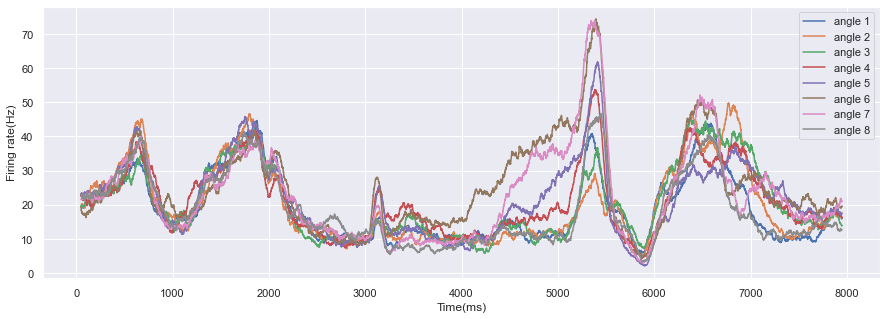

In [63]:
time = [t for t in range(0+50,8000-50)]
plt.figure(figsize=(15,5))
plt.xlabel('Time(ms)')
plt.ylabel('Firing rate(Hz)')
for angle in range(1,9):
    plt.plot(time,generate_time_series(get_angle_spike_train(responsive_data,angle)),label= "angle "+str(angle))
plt.legend()
plt.show()    

In [64]:
most_responsive = 6
least_responsive = 2
x = time
y_most = generate_time_series(get_angle_spike_train(responsive_data,most_responsive))
y_least = generate_time_series(get_angle_spike_train(responsive_data,least_responsive))
ci_most = 1.645 * np.std(y_most)/np.sqrt(len(y_most))
ci_least = 1.645 * np.std(y_least)/np.sqrt(len(y_most))

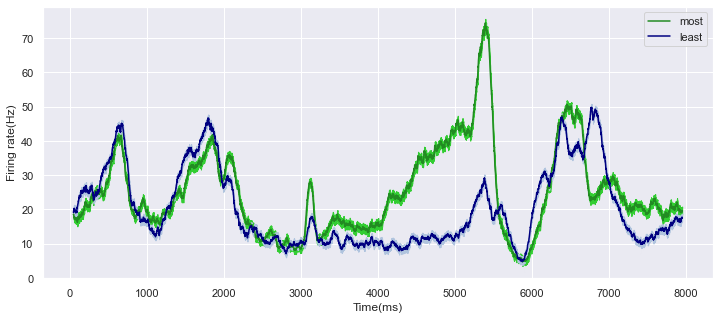

In [65]:
plt.figure(figsize=(12,5))
plt.xlabel('Time(ms)')
plt.ylabel('Firing rate(Hz)')

plt.plot(x,y_most,label = 'most',color = 'forestgreen')
plt.fill_between(x, (y_most-5*ci_most), (y_most+5*ci_most),color = 'limegreen')

plt.plot(x,y_least,label = 'least',color = 'navy')
plt.fill_between(x, (y_least-5*ci_least), (y_least+5*ci_least), color = 'lightsteelblue')

plt.legend()
plt.show() 

In [44]:
stats.ttest_ind(y_most, y_least)

Ttest_indResult(statistic=11.560808366811983, pvalue=8.658347137456707e-31)

# 3 Single Units: Measuring the Information

In [67]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [68]:
angle_data = np.where(stim_data>8,stim_data-8 ,stim_data)
time = [t for t in range(0,8000-50,5)]

In [69]:
info = {i:np.zeros(len(time)) for i in valids}
info[1][0] = 1

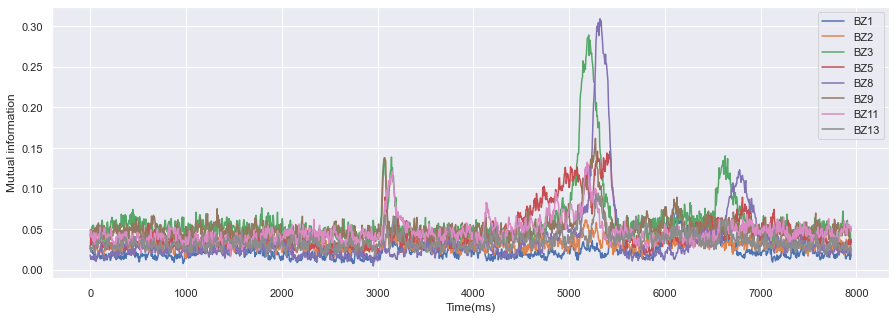

In [70]:
plt.figure(figsize=(15,5))
plt.xlabel('Time(ms)')
plt.ylabel('Mutual information')
info = {i:np.zeros(len(time)) for i in valids}
for i,file_name in enumerate(file_names):
    data = scipy.io.loadmat(file_name)['su'][0][0]
    for j,t in enumerate(range(0,8000-50,5)):
        r = np.mean(data[:,t:t+50],axis=1)
        info[valids[i]][j] = calc_MI(r,angle_data,50)
    plt.plot(time,info[valids[i]],label='BZ'+str(valids[i]))
plt.legend()
plt.show()    

In [71]:
sac = []
enc = []
for i in valids:
    sac.append(np.mean(info[i][976:1006]))
    enc.append(np.mean(info[i][610:640]))

Text(0, 0.5, 'Sac')

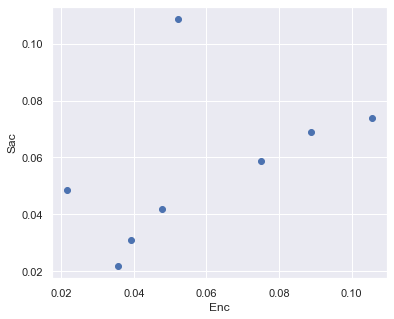

In [77]:
plt.figure(figsize=(6,5))
plt.scatter(enc,sac)
plt.xlabel('Enc')
plt.ylabel('Sac')

In [78]:
stats.ttest_ind(enc,sac)

Ttest_indResult(statistic=0.11119516651057591, pvalue=0.9130400105142564)

# 4 Population of Units: Quantifying the Information

In [96]:
data_matrix = np.zeros(shape= (963,8,8000))
for i,file_name in enumerate(file_names):
    data = scipy.io.loadmat(file_name)['su'][0][0]
    for j,trial in enumerate(data):
        data_matrix[j][i] = trial

In [97]:
time = [t for t in range(3000-1500,3000+1500,20)]
svm_angle_onset = np.zeros(shape=(8,len(time)))
svm_angle_saccade = np.zeros(shape=(8,len(time)))

### decoding angle

In [99]:
for seed in tqdm(range(50)):
    data_matrix_sh, angle_data_sh = shuffle(data_matrix,angle_data)
    X_train, X_test, y_train, y_test = train_test_split(data_matrix_sh,angle_data_sh, test_size=0.25, random_state=42)
    for t_idx,t in enumerate(time):
        clf1 = svm.SVC()
        clf2 = svm.SVC()
        clf1.fit(np.mean(X_train[:,:,t-75:t+75],2), y_train)
        pred1 = clf1.predict(np.mean(X_test[:,:,t-75:t+75],2))
        clf2.fit(np.mean(X_train[:,:,t+2000-75:t+2000+75],2), y_train)
        pred2 = clf2.predict(np.mean(X_test[:,:,t+2000-75:t+2000+75],2))
        cf1 = confusion_matrix(y_test,pred1)
        cf2 = confusion_matrix(y_test,pred2)
        for s in range(0,8):
            svm_angle_onset[s][t_idx] = svm_angle_onset[s][t_idx] + (cf1[s][s]/cf1[s].sum())
            svm_angle_saccade[s][t_idx] = svm_angle_saccade[s][t_idx] + (cf2[s][s]/cf2[s].sum())   

100%|██████████| 50/50 [18:11<00:00, 21.83s/it]


Text(140, 8.5, '1500')

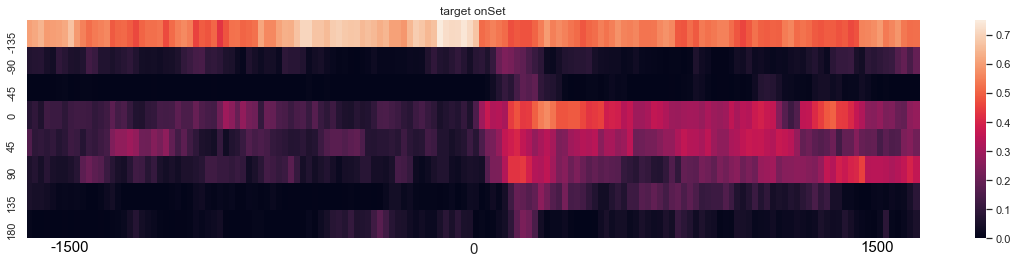

In [100]:
sns.set(rc = {'figure.figsize':(20,4)})
ax = plt.axes()
plot_data = np.zeros(shape=(8,len(time)))
ax = sns.heatmap(svm_angle_onset/50,yticklabels=[-135,-90,-45,0,45,90,135,180],xticklabels=[],ax = ax)
ax.set_title('target onSet')
plt.xlabel('0', fontsize = 15)
plt.text(4,8.5,'-1500', size=15, color='black')
plt.text(140,8.5,'1500', size=15, color='black')

Text(140, 8.5, '1500')

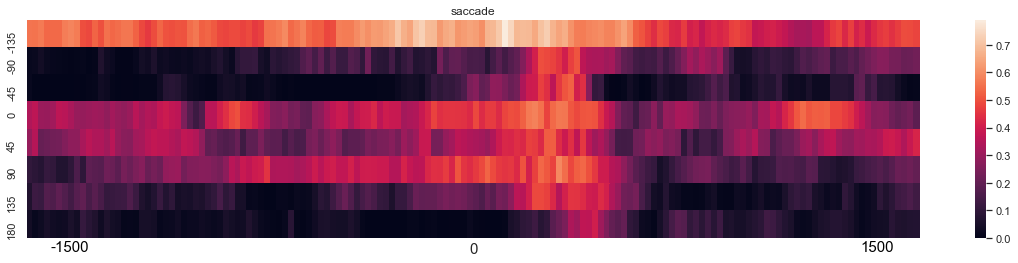

In [101]:
sns.set(rc = {'figure.figsize':(20,4)})
ax = plt.axes()
sns.heatmap(svm_angle_saccade/50,yticklabels=[-135,-90,-45,0,45,90,135,180],xticklabels=[],ax = ax)
ax.set_title('saccade')
plt.xlabel('0', fontsize = 15)
plt.text(4,8.5,'-1500', size=15, color='black')
plt.text(140,8.5,'1500', size=15, color='black')

### decoding radius

In [57]:
rad_data = np.where(stim_data>8,2,1)

In [58]:
time = [t for t in range(3000-1500,3000+1500,20)]
svm_rad_onset = np.zeros(shape=(2,len(time)))
svm_rad_saccade = np.zeros(shape=(2,len(time)))

In [59]:
for seed in tqdm(range(50)):
    X_train, X_test, y_train, y_test = train_test_split(data_matrix,rad_data, test_size=0.25, random_state=seed)
    for t_idx,t in enumerate(time):
        clf1 = svm.SVC()
        clf2 = svm.SVC()
        clf1.fit(np.mean(X_train[:,:,t-75:t+75],2), y_train)
        pred1 = clf1.predict(np.mean(X_test[:,:,t-75:t+75],2))
        clf2.fit(np.mean(X_train[:,:,t+2000-75:t+2000+75],2), y_train)
        pred2 = clf2.predict(np.mean(X_test[:,:,t+2000-75:t+2000+75],2))
        cf1 = confusion_matrix(y_test,pred1)
        cf2 = confusion_matrix(y_test,pred2)
        for r in range(0,2):
            svm_rad_onset[r][t_idx] = svm_rad_onset[r][t_idx] + (cf1[r][r]/cf1[r].sum()) 
            svm_rad_saccade[r][t_idx] = svm_rad_saccade[r][t_idx] + (cf2[r][r]/cf2[r].sum())   

100%|██████████| 50/50 [11:33<00:00, 13.86s/it]


Text(140, 2.3, '1500')

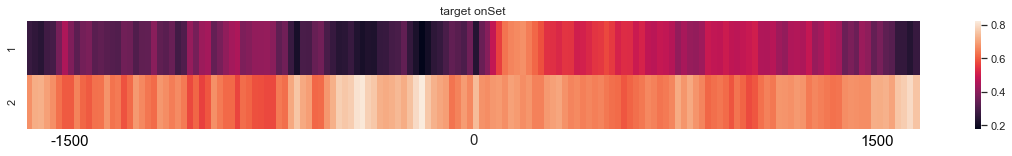

In [60]:
sns.set(rc = {'figure.figsize':(20,2)})
ax = plt.axes()
ax = sns.heatmap(svm_rad_onset/50,yticklabels=[1,2],xticklabels=[],ax = ax)
ax.set_title('target onSet')
plt.xlabel('0', fontsize = 15)
plt.text(4,2.3,'-1500', size=15, color='black')
plt.text(140,2.3,'1500', size=15, color='black')

Text(140, 2.3, '1500')

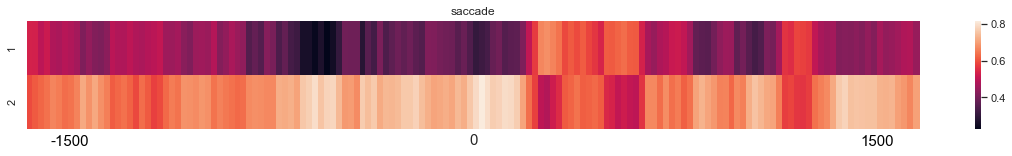

In [61]:
sns.set(rc = {'figure.figsize':(20,2)})
ax = plt.axes()
ax = sns.heatmap(svm_rad_saccade/50,yticklabels=[1,2],xticklabels=[],ax = ax)
ax.set_title('saccade')
plt.xlabel('0', fontsize = 15)
plt.text(4,2.3,'-1500', size=15, color='black')
plt.text(140,2.3,'1500', size=15, color='black')